# Training for Semantic Segmentation

Author: Farnaz Nouraei

Spring 2021, Brown University

## PREREQUISITES

In [2]:
import os
import yaml
import time
import shutil
import torch
import random
import argparse
import numpy as np

from torch.utils import data
from tqdm import tqdm

from tensorboardX import SummaryWriter


torch.backends.cudnn.enabled = True
print('Torch - Cuda Version: {}, is_cuda_available: {}'.format(torch.__version__, torch.cuda.is_available()))
if torch.cuda.is_available(): 
    print('Current Cuda Device:',torch.cuda.current_device())
    print('Device Name:',torch.cuda.get_device_name())
    CUDA_LAUNCH_BLOCKING=1


# Macros and Hyperparams

MODEL = "segnet" # {"segnet", "unet", "segnet_nocs", "segnetskip_nocs"}
DATASET = "egohands" # {"pascal", "egohands"}

OVERFIT = False # overfit on a subset of 200 pascal images

INPUT_SIZE = 128 # Input image width/height
OUTPUT_SIZE = 128 # Output image width/height (as defined by model)
if DATASET ==  "pascal":
    OUTPUT_CLASSES = 21 # Number of output classes in dataset (pascal)
if DATASET == "egohands":
    OUTPUT_CLASSES = 3 
IN_CHANNELS = 3      # RGB Input

# Training 

BATCH_SIZE = 8 # Batch - VRAM limited

LEARNING_RATE = 0.0001 # Model learning rate
WEIGHT_DECAY = 0.000001
MOMENTUM = 0.99

NUM_EPOCHS = 600 # Number of train steps per model train
DO_VAL = True
VAL_FREQ = 10 # How often we do validation
LOSS_SIGMOID_NORM = False # use a sigmoid normalization before DICE loss calculation
PRETRAINED = True # pretrain the model with VGG16 ImageNet parameters
LOSS_TYPE = "WBCE" # {"BCE" , "WBCE" , "Dice"}

# Saving

#MODEL_NAME = 'model_'+ MODEL # Model name to LOAD FROM (LOOKS IN SAVE_PATH DIRECTORY)
SAVE_FREQ = 100 # How often we save the model (epochs)


Torch - Cuda Version: 1.7.1, is_cuda_available: True
Current Cuda Device: 0
Device Name: GeForce GTX 1080 Ti


# Implementation 1

### Model Utilities

Borrowed from https://github.com/meetshah1995/pytorch-semseg

In [3]:
# model utilities


import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision.models as models


from torch.autograd import Variable

class conv2DBatchNorm(nn.Module):
    def __init__(
        self,
        in_channels,
        n_filters,
        k_size,
        stride,
        padding,
        bias=True,
        dilation=1,
        is_batchnorm=True,
    ):
        super(conv2DBatchNorm, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        if is_batchnorm:
            self.cb_unit = nn.Sequential(conv_mod, nn.BatchNorm2d(int(n_filters)))
        else:
            self.cb_unit = nn.Sequential(conv_mod)

    def forward(self, inputs):
        outputs = self.cb_unit(inputs)
        return outputs


class conv2DGroupNorm(nn.Module):
    def __init__(
        self, in_channels, n_filters, k_size, stride, padding, bias=True, dilation=1, n_groups=16
    ):
        super(conv2DGroupNorm, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        self.cg_unit = nn.Sequential(conv_mod, nn.GroupNorm(n_groups, int(n_filters)))

    def forward(self, inputs):
        outputs = self.cg_unit(inputs)
        return outputs


class deconv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding, bias=True):
        super(deconv2DBatchNorm, self).__init__()

        self.dcb_unit = nn.Sequential(
            nn.ConvTranspose2d(
                int(in_channels),
                int(n_filters),
                kernel_size=k_size,
                padding=padding,
                stride=stride,
                bias=bias,
            ),
            nn.BatchNorm2d(int(n_filters)),
        )

    def forward(self, inputs):
        outputs = self.dcb_unit(inputs)
        return outputs


class conv2DBatchNormRelu(nn.Module):
    def __init__(
        self,
        in_channels,
        n_filters,
        k_size,
        stride,
        padding,
        bias=True,
        dilation=1,
        is_batchnorm=True,
    ):
        super(conv2DBatchNormRelu, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        if is_batchnorm:
            self.cbr_unit = nn.Sequential(
                conv_mod, nn.BatchNorm2d(int(n_filters)), nn.ReLU(inplace=True)
            )
        else:
            self.cbr_unit = nn.Sequential(conv_mod, nn.ReLU(inplace=True))

    def forward(self, inputs):
        outputs = self.cbr_unit(inputs)
        return outputs


class conv2DGroupNormRelu(nn.Module):
    def __init__(
        self, in_channels, n_filters, k_size, stride, padding, bias=True, dilation=1, n_groups=16
    ):
        super(conv2DGroupNormRelu, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        self.cgr_unit = nn.Sequential(
            conv_mod, nn.GroupNorm(n_groups, int(n_filters)), nn.ReLU(inplace=True)
        )

    def forward(self, inputs):
        outputs = self.cgr_unit(inputs)
        return outputs


class deconv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding, bias=True):
        super(deconv2DBatchNormRelu, self).__init__()

        self.dcbr_unit = nn.Sequential(
            nn.ConvTranspose2d(
                int(in_channels),
                int(n_filters),
                kernel_size=k_size,
                padding=padding,
                stride=stride,
                bias=bias,
            ),
            nn.BatchNorm2d(int(n_filters)),
            nn.ReLU(inplace=True),
        )

    def forward(self, inputs):
        outputs = self.dcbr_unit(inputs)
        return outputs


class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm):
        super(unetConv2, self).__init__()

        if is_batchnorm:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_size, out_size, 3, 1, 0), nn.BatchNorm2d(out_size), nn.ReLU()
            )
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, 3, 1, 0), nn.BatchNorm2d(out_size), nn.ReLU()
            )
        else:
            self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, 3, 1, 0), nn.ReLU())
            self.conv2 = nn.Sequential(nn.Conv2d(out_size, out_size, 3, 1, 0), nn.ReLU())

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        return outputs


class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv):
        super(unetUp, self).__init__()
        self.conv = unetConv2(in_size, out_size, False)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, inputs1, inputs2):
        outputs2 = self.up(inputs2)
        offset = outputs2.size()[2] - inputs1.size()[2]
        padding = 2 * [offset // 2, offset // 2]
        outputs1 = F.pad(inputs1, padding)
        return self.conv(torch.cat([outputs1, outputs2], 1))


class segnetDown2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown2, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetDown3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown3, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetUp2(nn.Module): 
    def __init__(self, in_size, out_size):
        super(segnetUp2, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs


class segnetUp3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp3, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        return outputs


class residualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, n_filters, stride=1, downsample=None):
        super(residualBlock, self).__init__()

        self.convbnrelu1 = conv2DBatchNormRelu(in_channels, n_filters, 3, stride, 1, bias=False)
        self.convbn2 = conv2DBatchNorm(n_filters, n_filters, 3, 1, 1, bias=False)
        self.downsample = downsample
        self.stride = stride
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x

        out = self.convbnrelu1(x)
        out = self.convbn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out


class residualBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, n_filters, stride=1, downsample=None):
        super(residualBottleneck, self).__init__()
        self.convbn1 = nn.Conv2DBatchNorm(in_channels, n_filters, k_size=1, bias=False)
        self.convbn2 = nn.Conv2DBatchNorm(
            n_filters, n_filters, k_size=3, padding=1, stride=stride, bias=False
        )
        self.convbn3 = nn.Conv2DBatchNorm(n_filters, n_filters * 4, k_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.convbn1(x)
        out = self.convbn2(out)
        out = self.convbn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class linknetUp(nn.Module):
    def __init__(self, in_channels, n_filters):
        super(linknetUp, self).__init__()

        # B, 2C, H, W -> B, C/2, H, W
        self.convbnrelu1 = conv2DBatchNormRelu(
            in_channels, n_filters / 2, k_size=1, stride=1, padding=1
        )

        # B, C/2, H, W -> B, C/2, H, W
        self.deconvbnrelu2 = nn.deconv2DBatchNormRelu(
            n_filters / 2, n_filters / 2, k_size=3, stride=2, padding=0
        )

        # B, C/2, H, W -> B, C, H, W
        self.convbnrelu3 = conv2DBatchNormRelu(
            n_filters / 2, n_filters, k_size=1, stride=1, padding=1
        )

    def forward(self, x):
        x = self.convbnrelu1(x)
        x = self.deconvbnrelu2(x)
        x = self.convbnrelu3(x)
        return x


class FRRU(nn.Module):
    """
    Full Resolution Residual Unit for FRRN
    """

    def __init__(self, prev_channels, out_channels, scale, group_norm=False, n_groups=None):
        super(FRRU, self).__init__()
        self.scale = scale
        self.prev_channels = prev_channels
        self.out_channels = out_channels
        self.group_norm = group_norm
        self.n_groups = n_groups

        if self.group_norm:
            conv_unit = conv2DGroupNormRelu
            self.conv1 = conv_unit(
                prev_channels + 32,
                out_channels,
                k_size=3,
                stride=1,
                padding=1,
                bias=False,
                n_groups=self.n_groups,
            )
            self.conv2 = conv_unit(
                out_channels,
                out_channels,
                k_size=3,
                stride=1,
                padding=1,
                bias=False,
                n_groups=self.n_groups,
            )

        else:
            conv_unit = conv2DBatchNormRelu
            self.conv1 = conv_unit(
                prev_channels + 32, out_channels, k_size=3, stride=1, padding=1, bias=False
            )
            self.conv2 = conv_unit(
                out_channels, out_channels, k_size=3, stride=1, padding=1, bias=False
            )

        self.conv_res = nn.Conv2d(out_channels, 32, kernel_size=1, stride=1, padding=0)

    def forward(self, y, z):
        x = torch.cat([y, nn.MaxPool2d(self.scale, self.scale)(z)], dim=1)
        y_prime = self.conv1(x)
        y_prime = self.conv2(y_prime)

        x = self.conv_res(y_prime)
        upsample_size = torch.Size([_s * self.scale for _s in y_prime.shape[-2:]])
        x = F.upsample(x, size=upsample_size, mode="nearest")
        z_prime = z + x

        return y_prime, z_prime


class RU(nn.Module):
    """
    Residual Unit for FRRN
    """

    def __init__(self, channels, kernel_size=3, strides=1, group_norm=False, n_groups=None):
        super(RU, self).__init__()
        self.group_norm = group_norm
        self.n_groups = n_groups

        if self.group_norm:
            self.conv1 = conv2DGroupNormRelu(
                channels,
                channels,
                k_size=kernel_size,
                stride=strides,
                padding=1,
                bias=False,
                n_groups=self.n_groups,
            )
            self.conv2 = conv2DGroupNorm(
                channels,
                channels,
                k_size=kernel_size,
                stride=strides,
                padding=1,
                bias=False,
                n_groups=self.n_groups,
            )

        else:
            self.conv1 = conv2DBatchNormRelu(
                channels, channels, k_size=kernel_size, stride=strides, padding=1, bias=False
            )
            self.conv2 = conv2DBatchNorm(
                channels, channels, k_size=kernel_size, stride=strides, padding=1, bias=False
            )

    def forward(self, x):
        incoming = x
        x = self.conv1(x)
        x = self.conv2(x)
        return x + incoming


class residualConvUnit(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super(residualConvUnit, self).__init__()

        self.residual_conv_unit = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=kernel_size),
        )

    def forward(self, x):
        input = x
        x = self.residual_conv_unit(x)
        return x + input


class multiResolutionFusion(nn.Module):
    def __init__(self, channels, up_scale_high, up_scale_low, high_shape, low_shape):
        super(multiResolutionFusion, self).__init__()

        self.up_scale_high = up_scale_high
        self.up_scale_low = up_scale_low

        self.conv_high = nn.Conv2d(high_shape[1], channels, kernel_size=3)

        if low_shape is not None:
            self.conv_low = nn.Conv2d(low_shape[1], channels, kernel_size=3)

    def forward(self, x_high, x_low):
        high_upsampled = F.upsample(
            self.conv_high(x_high), scale_factor=self.up_scale_high, mode="bilinear"
        )

        if x_low is None:
            return high_upsampled

        low_upsampled = F.upsample(
            self.conv_low(x_low), scale_factor=self.up_scale_low, mode="bilinear"
        )

        return low_upsampled + high_upsampled


class chainedResidualPooling(nn.Module):
    def __init__(self, channels, input_shape):
        super(chainedResidualPooling, self).__init__()

        self.chained_residual_pooling = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.MaxPool2d(5, 1, 2),
            nn.Conv2d(input_shape[1], channels, kernel_size=3),
        )

    def forward(self, x):
        input = x
        x = self.chained_residual_pooling(x)
        return x + input


class pyramidPooling(nn.Module):
    def __init__(
        self, in_channels, pool_sizes, model_name="pspnet", fusion_mode="cat", is_batchnorm=True
    ):
        super(pyramidPooling, self).__init__()

        bias = not is_batchnorm

        self.paths = []
        for i in range(len(pool_sizes)):
            self.paths.append(
                conv2DBatchNormRelu(
                    in_channels,
                    int(in_channels / len(pool_sizes)),
                    1,
                    1,
                    0,
                    bias=bias,
                    is_batchnorm=is_batchnorm,
                )
            )

        self.path_module_list = nn.ModuleList(self.paths)
        self.pool_sizes = pool_sizes
        self.model_name = model_name
        self.fusion_mode = fusion_mode

    def forward(self, x):
        h, w = x.shape[2:]

        if self.training or self.model_name != "icnet":  # general settings or pspnet
            k_sizes = []
            strides = []
            for pool_size in self.pool_sizes:
                k_sizes.append((int(h / pool_size), int(w / pool_size)))
                strides.append((int(h / pool_size), int(w / pool_size)))
        else:  # eval mode and icnet: pre-trained for 1025 x 2049
            k_sizes = [(8, 15), (13, 25), (17, 33), (33, 65)]
            strides = [(5, 10), (10, 20), (16, 32), (33, 65)]

        if self.fusion_mode == "cat":  # pspnet: concat (including x)
            output_slices = [x]

            for i, (module, pool_size) in enumerate(zip(self.path_module_list, self.pool_sizes)):
                out = F.avg_pool2d(x, k_sizes[i], stride=strides[i], padding=0)
                # out = F.adaptive_avg_pool2d(x, output_size=(pool_size, pool_size))
                if self.model_name != "icnet":
                    out = module(out)
                out = F.interpolate(out, size=(h, w), mode="bilinear", align_corners=True)
                output_slices.append(out)

            return torch.cat(output_slices, dim=1)
        else:  # icnet: element-wise sum (including x)
            pp_sum = x

            for i, (module, pool_size) in enumerate(zip(self.path_module_list, self.pool_sizes)):
                out = F.avg_pool2d(x, k_sizes[i], stride=strides[i], padding=0)
                # out = F.adaptive_avg_pool2d(x, output_size=(pool_size, pool_size))
                if self.model_name != "icnet":
                    out = module(out)
                out = F.interpolate(out, size=(h, w), mode="bilinear", align_corners=True)
                pp_sum = pp_sum + out

            return pp_sum


class bottleNeckPSP(nn.Module):
    def __init__(
        self, in_channels, mid_channels, out_channels, stride, dilation=1, is_batchnorm=True
    ):
        super(bottleNeckPSP, self).__init__()

        bias = not is_batchnorm

        self.cbr1 = conv2DBatchNormRelu(
            in_channels, mid_channels, 1, stride=1, padding=0, bias=bias, is_batchnorm=is_batchnorm
        )
        if dilation > 1:
            self.cbr2 = conv2DBatchNormRelu(
                mid_channels,
                mid_channels,
                3,
                stride=stride,
                padding=dilation,
                bias=bias,
                dilation=dilation,
                is_batchnorm=is_batchnorm,
            )
        else:
            self.cbr2 = conv2DBatchNormRelu(
                mid_channels,
                mid_channels,
                3,
                stride=stride,
                padding=1,
                bias=bias,
                dilation=1,
                is_batchnorm=is_batchnorm,
            )
        self.cb3 = conv2DBatchNorm(
            mid_channels, out_channels, 1, stride=1, padding=0, bias=bias, is_batchnorm=is_batchnorm
        )
        self.cb4 = conv2DBatchNorm(
            in_channels,
            out_channels,
            1,
            stride=stride,
            padding=0,
            bias=bias,
            is_batchnorm=is_batchnorm,
        )

    def forward(self, x):
        conv = self.cb3(self.cbr2(self.cbr1(x)))
        residual = self.cb4(x)
        return F.relu(conv + residual, inplace=True)


class bottleNeckIdentifyPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation=1, is_batchnorm=True):
        super(bottleNeckIdentifyPSP, self).__init__()

        bias = not is_batchnorm

        self.cbr1 = conv2DBatchNormRelu(
            in_channels, mid_channels, 1, stride=1, padding=0, bias=bias, is_batchnorm=is_batchnorm
        )
        if dilation > 1:
            self.cbr2 = conv2DBatchNormRelu(
                mid_channels,
                mid_channels,
                3,
                stride=1,
                padding=dilation,
                bias=bias,
                dilation=dilation,
                is_batchnorm=is_batchnorm,
            )
        else:
            self.cbr2 = conv2DBatchNormRelu(
                mid_channels,
                mid_channels,
                3,
                stride=1,
                padding=1,
                bias=bias,
                dilation=1,
                is_batchnorm=is_batchnorm,
            )
        self.cb3 = conv2DBatchNorm(
            mid_channels, in_channels, 1, stride=1, padding=0, bias=bias, is_batchnorm=is_batchnorm
        )

    def forward(self, x):
        residual = x
        x = self.cb3(self.cbr2(self.cbr1(x)))
        return F.relu(x + residual, inplace=True)


class residualBlockPSP(nn.Module):
    def __init__(
        self,
        n_blocks,
        in_channels,
        mid_channels,
        out_channels,
        stride,
        dilation=1,
        include_range="all",
        is_batchnorm=True,
    ):
        super(residualBlockPSP, self).__init__()

        if dilation > 1:
            stride = 1

        # residualBlockPSP = convBlockPSP + identityBlockPSPs
        layers = []
        if include_range in ["all", "conv"]:
            layers.append(
                bottleNeckPSP(
                    in_channels,
                    mid_channels,
                    out_channels,
                    stride,
                    dilation,
                    is_batchnorm=is_batchnorm,
                )
            )
        if include_range in ["all", "identity"]:
            for i in range(n_blocks - 1):
                layers.append(
                    bottleNeckIdentifyPSP(
                        out_channels, mid_channels, stride, dilation, is_batchnorm=is_batchnorm
                    )
                )

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class cascadeFeatureFusion(nn.Module):
    def __init__(
        self, n_classes, low_in_channels, high_in_channels, out_channels, is_batchnorm=True
    ):
        super(cascadeFeatureFusion, self).__init__()

        bias = not is_batchnorm

        self.low_dilated_conv_bn = conv2DBatchNorm(
            low_in_channels,
            out_channels,
            3,
            stride=1,
            padding=2,
            bias=bias,
            dilation=2,
            is_batchnorm=is_batchnorm,
        )
        self.low_classifier_conv = nn.Conv2d(
            int(low_in_channels),
            int(n_classes),
            kernel_size=1,
            padding=0,
            stride=1,
            bias=True,
            dilation=1,
        )  # Train only
        self.high_proj_conv_bn = conv2DBatchNorm(
            high_in_channels,
            out_channels,
            1,
            stride=1,
            padding=0,
            bias=bias,
            is_batchnorm=is_batchnorm,
        )

    def forward(self, x_low, x_high):
        x_low_upsampled = F.interpolate(
            x_low, size=get_interp_size(x_low, z_factor=2), mode="bilinear", align_corners=True
        )

        low_cls = self.low_classifier_conv(x_low_upsampled)

        low_fm = self.low_dilated_conv_bn(x_low_upsampled)
        high_fm = self.high_proj_conv_bn(x_high)
        high_fused_fm = F.relu(low_fm + high_fm, inplace=True)

        return high_fused_fm, low_cls


def get_interp_size(input, s_factor=1, z_factor=1):  # for caffe
    ori_h, ori_w = input.shape[2:]

    # shrink (s_factor >= 1)
    ori_h = (ori_h - 1) / s_factor + 1
    ori_w = (ori_w - 1) / s_factor + 1

    # zoom (z_factor >= 1)
    ori_h = ori_h + (ori_h - 1) * (z_factor - 1)
    ori_w = ori_w + (ori_w - 1) * (z_factor - 1)

    resize_shape = (int(ori_h), int(ori_w))
    return resize_shape


def interp(input, output_size, mode="bilinear"):
    n, c, ih, iw = input.shape
    oh, ow = output_size

    # normalize to [-1, 1]
    h = torch.arange(0, oh, dtype=torch.float, device=input.device) / (oh - 1) * 2 - 1
    w = torch.arange(0, ow, dtype=torch.float, device=input.device) / (ow - 1) * 2 - 1

    grid = torch.zeros(oh, ow, 2, dtype=torch.float, device=input.device)
    grid[:, :, 0] = w.unsqueeze(0).repeat(oh, 1)
    grid[:, :, 1] = h.unsqueeze(0).repeat(ow, 1).transpose(0, 1)
    grid = grid.unsqueeze(0).repeat(n, 1, 1, 1)  # grid.shape: [n, oh, ow, 2]
    grid = Variable(grid)
    if input.is_cuda:
        grid = grid.cuda()

    return F.grid_sample(input, grid, mode=mode)


def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()



## SegNet Model

Implementation from https://github.com/meetshah1995/pytorch-semseg

In [4]:
# model definition

import torch.nn as nn
#from models.utils import segnetDown2, segnetDown3, segnetUp2, segnetUp3


class SegNet(nn.Module):
    def __init__(self, n_classes=21, in_channels=3, is_unpooling=True, pretrained = True):
        super(SegNet, self).__init__()

        self.in_channels = in_channels
        self.is_unpooling = is_unpooling
        self.n_classes= n_classes
        self.down1 = segnetDown2(self.in_channels, 64)
        self.down2 = segnetDown2(64, 128)
        self.down3 = segnetDown3(128, 256)
        self.down4 = segnetDown3(256, 512)
        self.down5 = segnetDown3(512, 512)

        self.up5 = segnetUp3(512, 512)
        self.up4 = segnetUp3(512, 256)
        self.up3 = segnetUp3(256, 128)
        self.up2 = segnetUp2(128, 64)
        self.up1 = segnetUp2(64, n_classes)
        
        if pretrained:
            vgg16 = models.vgg16(pretrained=True)
            Arch = 'SegNet'
            print('[ INFO ]: Using pre-trained weights from VGG16 with {}.'.format(Arch))
            self.init_vgg16_params(vgg16)

    
    def softmax(self,input):
        softmax = nn.Softmax(dim=1)
        out = softmax(input)
        return out

    def forward(self, inputs):

        down1, indices_1, unpool_shape1 = self.down1(inputs)
        down2, indices_2, unpool_shape2 = self.down2(down1)
        down3, indices_3, unpool_shape3 = self.down3(down2)
        down4, indices_4, unpool_shape4 = self.down4(down3)
        down5, indices_5, unpool_shape5 = self.down5(down4)

        up5 = self.up5(down5, indices_5, unpool_shape5)
        up4 = self.up4(up5, indices_4, unpool_shape4)
        up3 = self.up3(up4, indices_3, unpool_shape3)
        up2 = self.up2(up3, indices_2, unpool_shape2)
        up1 = self.up1(up2, indices_1, unpool_shape1)
        out = self.softmax(up1)
        
        return out

    def init_vgg16_params(self, vgg16):
        blocks = [self.down1, self.down2, self.down3, self.down4, self.down5]

        features = list(vgg16.features.children())

        vgg_layers = []
        for _layer in features:
            if isinstance(_layer, nn.Conv2d):
                vgg_layers.append(_layer)

        merged_layers = []
        for idx, conv_block in enumerate(blocks):
            if idx < 2:
                units = [conv_block.conv1.cbr_unit, conv_block.conv2.cbr_unit]
            else:
                units = [
                    conv_block.conv1.cbr_unit,
                    conv_block.conv2.cbr_unit,
                    conv_block.conv3.cbr_unit,
                ]
            for _unit in units:
                for _layer in _unit:
                    if isinstance(_layer, nn.Conv2d):
                        merged_layers.append(_layer)

        assert len(vgg_layers) == len(merged_layers)

        for l1, l2 in zip(vgg_layers, merged_layers):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
    
    def test(self, inp, ideal_out, device='cuda'):
        
        out = self.forward(inp)
        assert ideal_out.shape == out.shape
        import torchsummaryX
        torchsummaryX.summary(self, inp.to(device))
        print("Model test is complete")
        return out

In [5]:
### TEST THE MODEL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL == "segnet":
    model = SegNet(n_classes = OUTPUT_CLASSES)
    model = model.to(device)
    input_tensor = torch.rand(BATCH_SIZE, 3, INPUT_SIZE, INPUT_SIZE, device=device)
    ideal_out = torch.rand(BATCH_SIZE, OUTPUT_CLASSES, OUTPUT_SIZE, OUTPUT_SIZE, device=device)
    y = model.test(device = device
                   , inp = input_tensor
                   , ideal_out = ideal_out)
    print("test output shape:",y.shape)

[ INFO ]: Using pre-trained weights from VGG16 with SegNet.
                                            Kernel Shape       Output Shape  \
Layer                                                                         
0_down1.conv1.cbr_unit.Conv2d_0            [3, 64, 3, 3]  [8, 64, 128, 128]   
1_down1.conv1.cbr_unit.BatchNorm2d_1                [64]  [8, 64, 128, 128]   
2_down1.conv1.cbr_unit.ReLU_2                          -  [8, 64, 128, 128]   
3_down1.conv2.cbr_unit.Conv2d_0           [64, 64, 3, 3]  [8, 64, 128, 128]   
4_down1.conv2.cbr_unit.BatchNorm2d_1                [64]  [8, 64, 128, 128]   
5_down1.conv2.cbr_unit.ReLU_2                          -  [8, 64, 128, 128]   
6_down1.MaxPool2d_maxpool_with_argmax                  -    [8, 64, 64, 64]   
7_down2.conv1.cbr_unit.Conv2d_0          [64, 128, 3, 3]   [8, 128, 64, 64]   
8_down2.conv1.cbr_unit.BatchNorm2d_1               [128]   [8, 128, 64, 64]   
9_down2.conv1.cbr_unit.ReLU_2                          -   [8, 128, 64,

## UNet Model

Borrowed from https://github.com/meetshah1995/pytorch-semseg

In [ ]:
#model definition

import torch.nn as nn
#from ptsemseg.models.utils import unetConv2, unetUp

class unet(nn.Module):
    def __init__(
        self, feature_scale=4, n_classes=21, is_deconv=True, in_channels=3, is_batchnorm=True
    ):
        super(unet, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale

        filters = [64, 128, 256, 512, 1024]
        filters = [int(x / self.feature_scale) for x in filters]

        # downsampling
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.center = unetConv2(filters[3], filters[4], self.is_batchnorm)

        # upsampling
        self.up_concat4 = unetUp(filters[4], filters[3], self.is_deconv)
        self.up_concat3 = unetUp(filters[3], filters[2], self.is_deconv)
        self.up_concat2 = unetUp(filters[2], filters[1], self.is_deconv)
        self.up_concat1 = unetUp(filters[1], filters[0], self.is_deconv)

        # final conv (without any concat)
        self.final = nn.Conv2d(filters[0], n_classes, 1)

    def forward(self, inputs):
        conv1 = self.conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)

        center = self.center(maxpool4)
        up4 = self.up_concat4(conv4, center)
        up3 = self.up_concat3(conv3, up4)
        up2 = self.up_concat2(conv2, up3)
        up1 = self.up_concat1(conv1, up2)

        final = self.final(up1)

        return final
    
    def test(self, inp, ideal_out, device='cuda'):
        
        out = self.forward(inp)
        assert ideal_out.shape == out.shape
        import torchsummaryX
        torchsummaryX.summary(self, inp.to(device))
        print("Model test is complete")
        return out

In [ ]:
### TEST THE MODEL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL == "unet":
    model = unet(n_classes = OUTPUT_CLASSES)
    model = model.to(device)
    input_tensor = torch.rand(BATCH_SIZE, 3, INPUT_SIZE, INPUT_SIZE, device=device)
    ideal_out = torch.rand(BATCH_SIZE, OUTPUT_CLASSES, OUTPUT_SIZE, OUTPUT_SIZE, device=device)
    y = model.test(device = device
                   , inp = input_tensor
                   , ideal_out = ideal_out)
    print("test output shape:",y.shape)

# Implementation 2

### Model Utilities

Borrowed from https://github.com/cranberrymuffin/NOCS

In [ ]:
# Borrowed from https://github.com/meetshah1995/pytorch-semseg

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

from torch.autograd import Variable


class conv2DBatchNorm(nn.Module):
    def __init__(
        self,
        in_channels,
        n_filters,
        k_size,
        stride,
        padding,
        bias=True,
        dilation=1,
        is_batchnorm=True,
    ):
        super(conv2DBatchNorm, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        if is_batchnorm:
            self.cb_unit = nn.Sequential(conv_mod, nn.BatchNorm2d(int(n_filters)))
        else:
            self.cb_unit = nn.Sequential(conv_mod)

    def forward(self, inputs):
        outputs = self.cb_unit(inputs)
        return outputs


class conv2DGroupNorm(nn.Module):
    def __init__(
        self, in_channels, n_filters, k_size, stride, padding, bias=True, dilation=1, n_groups=16
    ):
        super(conv2DGroupNorm, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        self.cg_unit = nn.Sequential(conv_mod, nn.GroupNorm(n_groups, int(n_filters)))

    def forward(self, inputs):
        outputs = self.cg_unit(inputs)
        return outputs


class deconv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding, bias=True):
        super(deconv2DBatchNorm, self).__init__()

        self.dcb_unit = nn.Sequential(
            nn.ConvTranspose2d(
                int(in_channels),
                int(n_filters),
                kernel_size=k_size,
                padding=padding,
                stride=stride,
                bias=bias,
            ),
            nn.BatchNorm2d(int(n_filters)),
        )

    def forward(self, inputs):
        outputs = self.dcb_unit(inputs)
        return outputs


class conv2DBatchNormRelu(nn.Module):
    def __init__(
        self,
        in_channels,
        n_filters,
        k_size,
        stride,
        padding,
        bias=True,
        dilation=1,
        is_batchnorm=True,
    ):
        super(conv2DBatchNormRelu, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        if is_batchnorm:
            self.cbr_unit = nn.Sequential(
                conv_mod, nn.BatchNorm2d(int(n_filters)), nn.ReLU(inplace=True)
            )
        else:
            self.cbr_unit = nn.Sequential(conv_mod, nn.ReLU(inplace=True))

    def forward(self, inputs):
        outputs = self.cbr_unit(inputs)
        return outputs


class conv2DGroupNormRelu(nn.Module):
    def __init__(
        self, in_channels, n_filters, k_size, stride, padding, bias=True, dilation=1, n_groups=16
    ):
        super(conv2DGroupNormRelu, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        self.cgr_unit = nn.Sequential(
            conv_mod, nn.GroupNorm(n_groups, int(n_filters)), nn.ReLU(inplace=True)
        )

    def forward(self, inputs):
        outputs = self.cgr_unit(inputs)
        return outputs


class deconv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding, bias=True):
        super(deconv2DBatchNormRelu, self).__init__()

        self.dcbr_unit = nn.Sequential(
            nn.ConvTranspose2d(
                int(in_channels),
                int(n_filters),
                kernel_size=k_size,
                padding=padding,
                stride=stride,
                bias=bias,
            ),
            nn.BatchNorm2d(int(n_filters)),
            nn.ReLU(inplace=True),
        )

    def forward(self, inputs):
        outputs = self.dcbr_unit(inputs)
        return outputs

class segnetDown2(nn.Module):
    def __init__(self, in_size, out_size, withFeatureMap=False):
        super(segnetDown2, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)
        self.withFeatureMap = withFeatureMap

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        FeatureMap = outputs
        outputs, indices = self.maxpool_with_argmax(outputs)
        if self.withFeatureMap:
            return outputs, indices, FeatureMap
        return outputs, indices, None


class segnetDown3(nn.Module):
    def __init__(self, in_size, out_size, withFeatureMap=False):
        super(segnetDown3, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)
        self.withFeatureMap = withFeatureMap

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        FeatureMap = outputs
        outputs, indices = self.maxpool_with_argmax(outputs)
        if self.withFeatureMap:
            return outputs, indices, FeatureMap
        return outputs, indices, None

class segnetUp2(nn.Module):
    def __init__(self, in_size, out_size, withSkipConnections=False):
        super().__init__()
        self.withSkipConnections = withSkipConnections
        self.unpool = nn.MaxUnpool2d(2, 2)
        if self.withSkipConnections:
            self.conv1 = conv2DBatchNormRelu(2*in_size, 2*in_size, 3, 1, 1)
            self.conv2 = conv2DBatchNormRelu(2*in_size, out_size, 3, 1, 1)
        else:
            self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
            self.conv2 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape, SkipFeatureMap=None):
        if self.withSkipConnections and SkipFeatureMap is None:
            raise RuntimeError('Created SegNet with skip connections. But no feature map is passed.')

        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        if self.withSkipConnections:
            outputs = torch.cat((SkipFeatureMap, outputs), 1)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)

        return outputs


class segnetUp3(nn.Module):
    def __init__(self, in_size, out_size, withSkipConnections=False):
        super().__init__()
        self.withSkipConnections = withSkipConnections
        self.unpool = nn.MaxUnpool2d(2, 2)
        if self.withSkipConnections:
            self.conv1 = conv2DBatchNormRelu(2*in_size, 2*in_size, 3, 1, 1)
            self.conv2 = conv2DBatchNormRelu(2*in_size, 2*in_size, 3, 1, 1)
            self.conv3 = conv2DBatchNormRelu(2*in_size, out_size, 3, 1, 1)
        else:
            self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
            self.conv2 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
            self.conv3 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape, SkipFeatureMap=None):
        if self.withSkipConnections and SkipFeatureMap is None:
            raise RuntimeError('Created SegNet with skip connections. But no feature map is passed.')

        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        if self.withSkipConnections:
            outputs = torch.cat((SkipFeatureMap, outputs), 1)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        return outputs

# ------- UNet

class UNet_ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()

        self.Conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.BN = nn.BatchNorm2d(out_channels)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.Conv(x)
        x = self.BN(x)
        x = self.ReLU(x)

        return x

class UNet_DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.Block1 = UNet_ConvBlock(in_channels, out_channels, kernel_size=(3, 3), stride=1, padding=0) # Fixed kernel sizes
        self.Block2 = UNet_ConvBlock(out_channels, out_channels, kernel_size=(3, 3), stride=1, padding=0)
        self.Pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

    def forward(self, x):
        x = self.Block1(x)
        x = self.Block2(x)
        FeatureMap = x
        x = self.Pool(x)

        return x, FeatureMap

class UNet_UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_size):
        super().__init__()

        # Doing what's in the original paper: Upsample the feature map and then a 2x2 conv (and another upsample to match feature sizes)
        self.UpSample = nn.Upsample(size=up_size, mode='bilinear')
        self.Conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(2, 2), stride=1, padding=0)
        self.UpSample2 = nn.Upsample(size=up_size, mode='bilinear')
        self.Block1 = UNet_ConvBlock(in_channels, out_channels, kernel_size=(3, 3), stride=1, padding=0)
        self.Block2 = UNet_ConvBlock(out_channels, out_channels, kernel_size=(3, 3), stride=1, padding=0)

    def CopyCropConcat(self, Upsampled, CopiedFeatureMap):
        PadHalfSize = (CopiedFeatureMap.size()[2] - Upsampled.size()[2]) // 2 # Floor division //
        # print('PadHalfSize:', PadHalfSize)
        # Crop copied feature map
        # Remove PadHalfSize from both sides for both dimensions (starting from the last: width, then height)
        CopiedFeatureMap = F.pad(CopiedFeatureMap, (-PadHalfSize, -PadHalfSize, -PadHalfSize, -PadHalfSize))
        # print('CopiedFeatureMap:', CopiedFeatureMap.size())
        # print('Upsampled:', Upsampled.size())
        # Concat the features
        Concated = torch.cat((CopiedFeatureMap, Upsampled), 1) # Is this correct?
        # print('Concated:', Concated.size())
        return Concated

    def forward(self, x, CopiedFeatureMap):
        # print('-----------------------')
        # print('Input:', x.size())
        # Doing what's in the original paper: Upsample the feature map and then a 2x2 conv
        x = self.UpSample(x)
        x = self.Conv2(x)
        x = self.UpSample2(x)
        # Copy and crop here
        x = self.CopyCropConcat(x, CopiedFeatureMap)
        # print('After copycropconcat:', x.size())
        x = self.Block1(x)
        x = self.Block2(x)
        # print('Output:', x.size())
        # print('-----------------------')

        return x

## SegNet Model

Borrowed from https://github.com/cranberrymuffin/NOCS 

In [ ]:
# Borrowed from https://github.com/meetshah1995/pytorch-semseg
import torch.nn as nn
import os, sys

FileDirPath = "."

import torchvision.models as models

import numpy as np
import torch 

class SegNet(nn.Module):
    def __init__(self, n_classes=21, in_channels=3, is_unpooling=True
                 , DataParallelDevs=None, pretrained=True, withSkipConnections=False):
        
        super(SegNet, self).__init__()

        self.in_channels = in_channels
        self.is_unpooling = is_unpooling
        self.withSkipConnections = withSkipConnections
        self.isPretrained = pretrained

        self.down1 = segnetDown2(self.in_channels, 64, withFeatureMap=self.withSkipConnections)
        self.down2 = segnetDown2(64, 128, withFeatureMap=self.withSkipConnections)
        self.down3 = segnetDown3(128, 256, withFeatureMap=self.withSkipConnections)
        self.down4 = segnetDown3(256, 512, withFeatureMap=self.withSkipConnections)
        self.down5 = segnetDown3(512, 512, withFeatureMap=self.withSkipConnections)

        self.up5 = segnetUp3(512, 512, withSkipConnections=self.withSkipConnections)
        self.up4 = segnetUp3(512, 256, withSkipConnections=self.withSkipConnections)
        self.up3 = segnetUp3(256, 128, withSkipConnections=self.withSkipConnections)
        self.up2 = segnetUp2(128, 64, withSkipConnections=self.withSkipConnections)
        self.up1 = segnetUp2(64, n_classes, withSkipConnections=self.withSkipConnections)

        if DataParallelDevs is not None:
            if len(DataParallelDevs) > 1:
                self.down1 = nn.DataParallel(self.down1, device_ids=DataParallelDevs)
                self.down2 = nn.DataParallel(self.down2, device_ids=DataParallelDevs)
                self.down3 = nn.DataParallel(self.down3, device_ids=DataParallelDevs)
                self.down4 = nn.DataParallel(self.down4, device_ids=DataParallelDevs)
                self.down5 = nn.DataParallel(self.down5, device_ids=DataParallelDevs)

                self.up1 = nn.DataParallel(self.up1, device_ids=DataParallelDevs)
                self.up2 = nn.DataParallel(self.up2, device_ids=DataParallelDevs)
                self.up3 = nn.DataParallel(self.up3, device_ids=DataParallelDevs)
                self.up4 = nn.DataParallel(self.up4, device_ids=DataParallelDevs)
                self.up5 = nn.DataParallel(self.up5, device_ids=DataParallelDevs)

        if pretrained:
            vgg16 = models.vgg16(pretrained=True)
            Arch = 'SegNet'
            if self.withSkipConnections:
                Arch = 'SegNetSkip'
            print('[ INFO ]: Using pre-trained weights from VGG16 with {}.'.format(Arch))
            self.init_vgg16_params(vgg16)

    def forward(self, inputs):
        B, C, W, H = inputs.size()
        
        down1, indices_1, FM1 = self.down1(inputs)
        down2, indices_2, FM2 = self.down2(down1)
        down3, indices_3, FM3 = self.down3(down2)
        down4, indices_4, FM4 = self.down4(down3)
        down5, indices_5, FM5 = self.down5(down4)

        #make the outputs for downs satisfy multi-gpu requirement
        scale = np.array((1,1,2,2))
        unpool_shape1 = torch.Size(down1.size() * scale)
        unpool_shape2 = torch.Size((unpool_shape1 / scale).astype(int))
        unpool_shape3 = torch.Size((unpool_shape2 / scale).astype(int))
        unpool_shape4 = torch.Size((unpool_shape3 / scale).astype(int))
        unpool_shape5 = torch.Size((unpool_shape4 / scale).astype(int))

        up5 = self.up5(down5, indices_5, unpool_shape5, SkipFeatureMap=FM5)
        up4 = self.up4(up5, indices_4, unpool_shape4, SkipFeatureMap=FM4)
        up3 = self.up3(up4, indices_3, unpool_shape3, SkipFeatureMap=FM3)
        up2 = self.up2(up3, indices_2, unpool_shape2, SkipFeatureMap=FM2)
        up1 = self.up1(up2, indices_1, unpool_shape1, SkipFeatureMap=FM1)

        # # DEBUG: print sizes
        # print('down1:', down1.size())
        # print('down2:', down2.size())
        # print('down3:', down3.size())
        # print('down4:', down4.size())
        # print('down5:', down5.size())
        #
        # print('up5:', up5.size())
        # print('up4:', up4.size())
        # print('up3:', up3.size())
        # print('up2:', up2.size())
        # print('up1:', up1.size())

        return up1

    def init_vgg16_params(self, vgg16):
        blocks = [self.down1, self.down2, self.down3, self.down4, self.down5]
        for i in range(len(blocks)):
            if type(blocks[i]) == nn.DataParallel:
                blocks[i] = blocks[i].module

        features = list(vgg16.features.children())

        vgg_layers = []
        for _layer in features:
            if isinstance(_layer, nn.Conv2d):
                vgg_layers.append(_layer)

        merged_layers = []
        for idx, conv_block in enumerate(blocks):
            if idx < 2:
                units = [conv_block.conv1.cbr_unit, conv_block.conv2.cbr_unit]
            else:
                units = [
                    conv_block.conv1.cbr_unit,
                    conv_block.conv2.cbr_unit,
                    conv_block.conv3.cbr_unit,
                ]
            for _unit in units:
                for _layer in _unit:
                    if isinstance(_layer, nn.Conv2d):
                        merged_layers.append(_layer)

        assert len(vgg_layers) == len(merged_layers)

        for l1, l2 in zip(vgg_layers, merged_layers):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
                
    def test(self, inp, ideal_out, device='cuda'):
        
        out = self.forward(inp)
        assert ideal_out.shape == out.shape
        import torchsummaryX
        torchsummaryX.summary(self, inp.to(device))
        print("Model test is complete")
        return out

In [ ]:
### TEST THE MODEL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL == "segnet_nocs": 
    model = SegNet(n_classes = OUTPUT_CLASSES, withSkipConnections=False)
if MODEL == "segnet": 
    model = SegNet(n_classes = OUTPUT_CLASSES, withSkipConnections=True)
    
model = model.to(device)
input_tensor = torch.rand(BATCH_SIZE, 3, INPUT_SIZE, INPUT_SIZE, device=device)
ideal_out = torch.rand(BATCH_SIZE, OUTPUT_CLASSES, OUTPUT_SIZE, OUTPUT_SIZE, device=device)
y = model.test(device = device
               , inp = input_tensor
               , ideal_out = ideal_out)
print("test output shape:",y.shape)

# Implementation 3 - UNet

### Model Utilities

from: https://github.com/milesial/Pytorch-UNet

In [ ]:
# model utilities

""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
# model definition

import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, in_channels=3, n_classes=21, bilinear=True):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    
    def softmax(self,input):
        softmax = nn.Softmax(dim=1)
        out = softmax(input)
        return out

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        out = self.softmax(logits)
        
        return out
    
    def test(self, inp, ideal_out, device='cuda'):
        
        out = self.forward(inp)
        assert ideal_out.shape == out.shape
        import torchsummaryX
        torchsummaryX.summary(self, inp.to(device))
        print("Model test is complete")
        return out

In [ ]:
### TEST THE MODEL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL == "unet":
    model = UNet(n_classes = OUTPUT_CLASSES)
    model = model.to(device)
    input_tensor = torch.rand(BATCH_SIZE, 3, INPUT_SIZE, INPUT_SIZE, device=device)
    ideal_out = torch.rand(BATCH_SIZE, 21, OUTPUT_SIZE, OUTPUT_SIZE, device=device)
    y = model.test(device = device
                   , inp = input_tensor
                   , ideal_out = ideal_out)
    print("test output shape:",y.shape)

## LOGGER

In [7]:
import os
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import time
import shutil
import pathlib

dict_class_names = {"pascal":  # For more datasets, add more keys
                    
                    ["bg"
                     ,"aeroplane"
                     ,"bicycle"  
                     ,"bird" 
                     ,"boat"  
                     ,"bottle"  
                     ,"bus" 
                     ,"car" 
                     ,"cat"
                     ,"chair"
                     ,"cow"
                     ,"dining table" 
                     ,"dog"
                     ,"horse"
                     ,"motorbike" 
                     ,"person"
                     ,"potted plant"
                     ,"sheep"
                     ,"sofa"
                     ,"train"
                     ,"tv/monitor"]   
                    
                    
                    , "egohands":
                    ["bg"
                     ,"left"
                     ,"right"]
                                   
                   } 

def datestr():
    now = time.gmtime()
    return '{:02}_{:02}__{:02}_{:02}'.format(now.tm_mday, now.tm_mon, now.tm_hour, now.tm_min)

def make_dirs(path):
    try:
        pathlib.Path(path).mkdir(parents=True, exist_ok=True)
    except FileExistsError:
        pass
    
class TensorboardWriter():

    def __init__(self, model_name, dataset_name, classes, root):

        name_model = str(model_name) + "_" + dataset_name + "_" + datestr()
        make_dirs(os.path.join(root,"logs",name_model))
        
        self.writer = SummaryWriter(os.path.join(root,"logs",name_model), comment=name_model)

        self.csv_train, self.csv_val = self.create_stats_files(os.path.join(root,"logs"))
        self.dataset_name = dataset_name
        self.label_names = dict_class_names[dataset_name]
        self.val_frequency = VAL_FREQ
        self.data = self.create_data_structure()

    def create_data_structure(self, ):
        data = {"train": dict((label, 0.0) for label in self.label_names),
                "val": dict((label, 0.0) for label in self.label_names)}
        data['train']['loss'] = 0.0
        data['val']['loss'] = 0.0
        data['train']['count'] = 1.0
        data['val']['count'] = 1.0
        data['train']['dsc'] = 0.0
        data['val']['dsc'] = 0.0
        return data
        
    def display_terminal(self, iter, epoch, mode='train', summary=False):
        """
        :param iter: iteration or partial epoch
        :param epoch: epoch of training
        :param loss: any loss numpy
        :param mode: train or val ( for training and validation)
        :param summary: to print total statistics at the end of epoch
        """
        if summary:
            info_print = "\nSummary {} Epoch {:2d}:  Loss:{:.4f} \t DSC:{:.4f}  ".format(mode, epoch,
                                                                                         self.data[mode]['loss'] /
                                                                                         self.data[mode]['count'],
                                                                                         self.data[mode]['dsc'] /
                                                                                         self.data[mode]['count'])

            for i in range(len(self.label_names)):
                info_print += "\t{} : {:.4f}".format(self.label_names[i],
                                                     self.data[mode][self.label_names[i]] / self.data[mode]['count'])

            print(info_print)
        else:

            info_print = "\nEpoch: {:.2f} Loss:{:.4f} \t DSC:{:.4f}".format(iter, self.data[mode]['loss'] /
                                                                            self.data[mode]['count'],
                                                                            self.data[mode]['dsc'] /
                                                                            self.data[mode]['count'])

            for i in range(len(self.label_names)):
                info_print += "\t{}:{:.4f}".format(self.label_names[i],
                                                   self.data[mode][self.label_names[i]] / self.data[mode]['count'])
            print(info_print)

    def create_stats_files(self, path):
        train_f = open(os.path.join(path, 'train.csv'), 'w')
        val_f = open(os.path.join(path, 'val.csv'), 'w')
        return train_f, val_f

    def reset(self, mode):
        self.data[mode]['dsc'] = 0.0
        self.data[mode]['loss'] = 0.0
        self.data[mode]['count'] = 1
        for i in range(len(self.label_names)):
            self.data[mode][self.label_names[i]] = 0.0

    def update_scores(self, iter, loss, mode, writer_step, channel_score= np.zeros(OUTPUT_CLASSES, dtype = np.float32)):
        """
        :param iter: iteration or partial epoch
        :param loss: any loss torch.tensor.item()
        :param channel_score: per channel score or dice coef
        :param mode: train or val ( for training and validation)
        :param writer_step: tensorboard writer step
        """
        # WARNING ASSUMING THAT CHANNELS IN SAME ORDER AS DICTIONARY
        
        #calculate dice loss
        dice_coeff = np.mean(channel_score) * 100


        num_channels = len(channel_score)
        self.data[mode]['dsc'] += dice_coeff
        self.data[mode]['loss'] += loss
        self.data[mode]['count'] = iter + 1

        for i in range(num_channels):
            self.data[mode][self.label_names[i]] += channel_score[i]
            if self.writer is not None:
                self.writer.add_scalar(mode + '/' + self.label_names[i], channel_score[i], global_step=writer_step)

    def write_end_of_epoch(self, epoch):

        self.writer.add_scalars('DSC/', {'train': self.data['train']['dsc'] / self.data['train']['count'],
                                         'val': self.data['val']['dsc'] / self.data['val']['count'],
                                         }, epoch)
        self.writer.add_scalars('Loss/', {'train': self.data['train']['loss'] / self.data['train']['count'],
                                          'val': self.data['val']['loss'] / self.data['val']['count'],
                                          }, epoch)
        for i in range(len(self.label_names)):
            self.writer.add_scalars(self.label_names[i],
                                    {'train': self.data['train'][self.label_names[i]] / self.data['train']['count'],
                                     'val': self.data['val'][self.label_names[i]] / self.data['train']['count'],
                                     }, epoch)

        train_csv_line = 'Epoch:{:2d} Loss:{:.4f} DSC:{:.4f}'.format(epoch
                             ,self.data['train']['loss'] / self.data['train']['count']
                             ,self.data['train']['dsc'] / self.data['train']['count'])
        if ((epoch+1)%self.val_frequency):
            val_csv_line = 'Epoch:{:2d} Loss:{:.4f} DSC:{:.4f}'.format(epoch
                           ,self.data['val']['loss'] / self.data['val']['count']
                           ,self.data['val']['dsc'] / self.data['val']['count'])
            self.csv_val.write(val_csv_line + '\n')
        
        
        self.csv_train.write(train_csv_line + '\n')
        
        return epoch, self.data['train']['loss'] / self.data['train']['count'],self.data['val']['loss'] / self.data['val']['count']


## TRAINER

In [1]:
# data preparation to input to the model

def prepare_input(input_tuple, inModalities=1, inChannels=3, cuda=True if torch.cuda.is_available() else False, args=None):
    
    modalities = inModalities
    channels = inChannels
    in_cuda = cuda
    if modalities == 4:
        if channels == 4:
            img_1, img_2, img_3, img_4, target = input_tuple
            input_tensor = torch.cat((img_1, img_2, img_3, img_4), dim=1)
        elif channels == 3:
            # t1 post constast is ommited
            img_1, _, img_3, img_4, target = input_tuple
            input_tensor = torch.cat((img_1, img_3, img_4), dim=1)
        elif channels == 2:
            # t1 and t2 only
            img_1, _, img_3, _, target = input_tuple
            input_tensor = torch.cat((img_1, img_3), dim=1)
        elif channels == 1:
            # t1 only
            input_tensor, _, _, target = input_tuple
    if modalities == 3:
        if channels == 3:
            img_1, img_2, img_3, target = input_tuple
            input_tensor = torch.cat((img_1, img_2, img_3), dim=1)
        elif channels == 2:
            img_1, img_2, _, target = input_tuple
            input_tensor = torch.cat((img_1, img_2), dim=1)
        elif channels == 1:
            input_tensor, _, _, target = input_tuple
    elif modalities == 2:
        if channels == 2:
            img_t1, img_t2, target = input_tuple

            input_tensor = torch.cat((img_t1, img_t2), dim=1)

        elif channels == 1:
            input_tensor, _, target = input_tuple
    elif modalities == 1:
        input_tensor, target, flo_tensor = input_tuple

    if in_cuda:
        input_tensor, target, flo_tensor = input_tensor.cuda(), target.cuda(), flo_tensor.cuda()
        
    return input_tensor, target, flo_tensor



# helper for saving models

def save_model(model,file_name,root_path,epoch,optimizer,val_loss,model_name,learning_rate,loss_type):
    
    make_dirs(os.path.join(root_path,"trained/"+model_name,"checkpoints"))
    torch.save({
            'epoch': epoch
            ,'model_state_dict': model.state_dict()
            ,'optimizer_state_dict': optimizer.state_dict()
            ,'val_loss': val_loss
                }, os.path.join(root_path,"trained/"+model_name,"checkpoints",file_name+".ckpt"))
    
    make_dirs(os.path.join(root_path,"trained/"+model_name,"models"))
    torch.save(model.state_dict(), os.path.join(root_path,"trained/",model_name,"models",file_name+"_"+loss_type+".pth"))
    
    print("MODEL SAVED AT EPOCH {}".format(epoch))

    
    
# helper for loss plotting

def plot_losses(do_validation, val_frequency
                ,train_loss_list,val_loss_list
                ,epoch_list,val_epoch_list,epoch
                ,train_loss,val_loss
                ,model_name,filename = "./losses_",learning_rate = LEARNING_RATE,loss_type=LOSS_TYPE): 
    
    train_loss_list.append(train_loss)
    
    if do_validation and ((epoch+1)%val_frequency)==0:
        val_loss_list.append(val_loss)
        val_epoch_list.append(epoch)

    epoch_list.append(epoch)
    plt.plot(epoch_list,train_loss_list,'b-',val_epoch_list,val_loss_list,'r-')
    plt.xlabel("epoch")
    plt.ylabel("loss(red=val)")
    plt.savefig(filename+model_name+"_ep"+str(epoch_list[-1])+"_lr"+str(learning_rate)+"_"+str(loss_type)+".png")
    return
    

NameError: name 'torch' is not defined

In [9]:
# Trainer Class

class Trainer:
    """
    Trainer class (Torch)
    """
    def __init__(self, train_data_loader, valid_data_loader, root, nEpochs 
                 , terminal_show_freq, classes, model, criterion, optimizer 
                 , model_name = MODEL, lr_scheduler= None
                 , dataset_name = DATASET, do_save= True
                 , pretrained = PRETRAINED
                 , device = "cuda" if torch.cuda.is_available() else "cpu"):

        self.nEpochs = nEpochs
        self.learning_rate = LEARNING_RATE
        self.pretrained = pretrained
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.train_data_loader = train_data_loader
        # epoch-based training
        self.len_epoch = len(self.train_data_loader)
        self.valid_data_loader = valid_data_loader
        self.do_validation = DO_VAL 
        self.val_frequency = VAL_FREQ
        self.lr_scheduler = lr_scheduler
        self.log_step = int(np.sqrt(train_data_loader.batch_size))
        self.model_name = model_name
        self.writer = TensorboardWriter(model_name,dataset_name,classes,root)
        self.terminal_show_freq = terminal_show_freq
        self.do_save = do_save
        self.save_frequency = SAVE_FREQ 
        self.root = root
        self.terminal_show_freq = self.terminal_show_freq
        self.start_epoch = 1
        self.dataset_name = dataset_name
        self.train_loss_list = []
        self.val_loss_list = []
        self.epoch_list = []
        self.val_epoch_list = []
        
    def training(self):
        
        for epoch in range(self.start_epoch, self.nEpochs):
            
            self.train_epoch(epoch)

            if self.do_validation and ((epoch+1)%self.val_frequency)==0:
                self.validate_epoch(epoch)
                val_loss = self.writer.data['val']['loss'] / self.writer.data['val']['count']
                if self.lr_scheduler is not None:
                    self.lr_scheduler.step(val_loss)
                    print("LR: ",self.optimizer.param_groups[0]['lr'])
            else:
                val_loss = np.nan    # used if saving happens before validation or no val is performed
            
            # save model every "save_frequency" epochs (Note that this overwrites the last model)
            if self.do_save is True and ((epoch + 1) % self.save_frequency)==0:
               
                self.save_file = '{}_{}_ep{}_lr{}_bs{}'.format(self.model_name
                                                          ,self.dataset_name
                                                          ,self.nEpochs
                                                          ,self.learning_rate
                                                          ,BATCH_SIZE)
                if self.pretrained == True: self.save_file = self.save_file+"_pretrained"

                save_model(model=self.model
                           ,file_name=self.save_file
                           ,root_path = self.root
                           ,epoch=epoch,optimizer=self.optimizer
                           ,val_loss=val_loss
                           ,model_name = self.model_name
                           ,learning_rate = LEARNING_RATE
                           ,loss_type = LOSS_TYPE) 
            

            
            epoch_num, epoch_loss_train, epoch_loss_val = self.writer.write_end_of_epoch(epoch)
            
            plot_losses(do_validation = self.do_validation
                        ,val_frequency= self.val_frequency
                        ,train_loss_list=self.train_loss_list
                        ,val_loss_list = self.val_loss_list
                        ,epoch_list=self.epoch_list
                        ,val_epoch_list = self.val_epoch_list
                        ,epoch = epoch
                        ,train_loss = epoch_loss_train
                        ,val_loss = epoch_loss_val
                        ,model_name = self.model_name )
            #print(self.train_loss_list)
            self.writer.reset('train')
            self.writer.reset('val')
            
            
    
    def train_epoch(self, epoch):

        self.model.train()

        for batch_idx, input_tuple in enumerate(self.train_data_loader):

            self.optimizer.zero_grad()

            input_tensor, target, flo_tensor = prepare_input(input_tuple=input_tuple, args=None)
            input_tensor.requires_grad = True
            flo_tensor.requires_grad = True
                
            #output = self.model(input_tensor) #TODO: image/flo or both
            output = self.model(flo_tensor)
            
            loss, per_ch_score = self.criterion(output, target) 

            loss.backward()

            self.optimizer.step()
            
            if LOSS_TYPE == "Dice":
                self.writer.update_scores(batch_idx, loss.item(), 'train' 
                                          , epoch * self.len_epoch + batch_idx
                                          , channel_score = per_ch_score) 
            else:
                self.writer.update_scores(batch_idx, loss.item(), 'train' 
                                          , epoch * self.len_epoch + batch_idx)
    
            # shows loss of partial epoch:
        
            #if (batch_idx + 1) % self.terminal_show_freq == 0:
                #partial_epoch = epoch + batch_idx / self.len_epoch - 1
                #self.writer.display_terminal(partial_epoch, epoch, 'train')

        self.writer.display_terminal(self.len_epoch, epoch, mode='train', summary=True)

    def validate_epoch(self, epoch):
        
        self.model.eval()

        for batch_idx, input_tuple in enumerate(self.valid_data_loader):
            with torch.no_grad():
                input_tensor, target = prepare_input(input_tuple=input_tuple, args=None)
                input_tensor.requires_grad = False

                output = self.model(input_tensor)
                
                loss, per_ch_score = self.criterion(output, target)
            
            if LOSS_TYPE == "Dice":
                self.writer.update_scores(batch_idx, loss.item(), 'val'
                                         , epoch * self.len_epoch + batch_idx
                                         , channel_score = per_ch_score) #comment this line if not using "Dice" loss
            else:
                self.writer.update_scores(batch_idx, loss.item(), 'val'
                                         , epoch * self.len_epoch + batch_idx)
                                                          
        if ((epoch+1)%self.val_frequency)==0:
        
            self.writer.display_terminal(len(self.valid_data_loader), epoch, mode='val', summary=True)
        

## LOSS

In [10]:
from torch import nn as nn

def expand_as_one_hot(input, C, ignore_index=None):
    """
    Converts NxDxHxW label image (D=1 for pascal labels) to NxCxDxHxW, where each label gets converted to its corresponding one-hot vector
    :param input: 4D input image (NxDxHxW)
    :param C: number of channels/labels
    :param ignore_index: ignore index to be kept during the expansion
    :return: 5D output image (NxCxDxHxW)
    """
    if input.dim() == 4: 
        return input
    assert input.dim() == 3

    # expand the input tensor to Nx1x1xHxW before scattering -- N=batch_size, C=n_classes 
    input = input.unsqueeze(1)
    # create result tensor shape (NxCx1xHxW)
    shape = list(input.size())
    #print('one_hot_expanded shape: ',shape)
    shape[1] = C
    #print('one_hot_expanded shape with classes',shape)

    if ignore_index is not None:
        # create ignore_index mask for the result
        mask = input.expand(shape) == ignore_index
        # clone the lib tensor and zero out ignore_index in the input
        input = input.clone()
        input[input == ignore_index] = 0
        # scatter to get the one-hot tensor
        result = torch.zeros(shape).to(input.device).scatter_(1, input, 1)
        # bring back the ignore_index in the result
        result[mask] = ignore_index
        return result
    else:
        # scatter to get the one-hot tensor
        return torch.zeros(shape).to(input.device).scatter_(1, input, 1)


def compute_per_channel_dice(input, target, epsilon=1e-6, weight=None):
    """
    Computes DiceCoefficient as defined in https://arxiv.org/abs/1606.04797 given  a multi channel input and target.
    Assumes the input is a normalized probability, e.g. a result of Sigmoid or Softmax function.
    Args:
         input (torch.Tensor): NxCxSpatial input tensor
         target (torch.Tensor): NxCxSpatial target tensor
         epsilon (float): prevents division by zero
         weight (torch.Tensor): Cx1 tensor of weight per channel/class
    """

    # input and target shapes must match
    assert input.size() == target.size(), " 'input' and 'target' must have the same shape "

    input = flatten(input)
    target = flatten(target)
    target = target.float()

    # compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    # here we can use standard dice (input + target).sum(-1) or extension (see V-Net) (input^2 + target^2).sum(-1)
    denominator = (input * input).sum(-1) + (target * target).sum(-1)
    return 2 * (intersect / denominator.clamp(min=epsilon))


def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, H, W) -> (C, N * H * W)
    """
    # number of channels
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.contiguous().view(C, -1)

class Identity:  
    def __init__(self):
        pass
    def __call__(self,x):
        return x



# Code was adapted and modified from https://github.com/wolny/pytorch-3dunet/blob/master/pytorch3dunet/unet3d/losses.py

class _AbstractDiceLoss(nn.Module):
    """
    Base class for different implementations of Dice loss.
    """

    def __init__(self, weight=None, sigmoid_normalization=LOSS_SIGMOID_NORM):
        super(_AbstractDiceLoss, self).__init__()
        self.register_buffer('weight', weight)
        self.classes = None
        self.skip_index_after = None
        # The output from the network during training is assumed to be un-normalized probabilities and we would
        # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
        # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
        # However if one would like to apply Softmax in order to get the proper probability distribution from the
        # output, just specify sigmoid_normalization=False.
        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = Identity()
            #self.normalization = nn.Softmax(dim=1)

    def dice(self, input, target, weight):
        # actual Dice score computation; to be implemented by the subclass
        raise NotImplementedError

    def skip_target_channels(self, target, index):
        """
        Assuming dim 1 is the classes dim , it skips all the indexes after the desired class
        """
        assert index >= 2
        return target[:, 0:index, ...]

    def forward(self, input, target):
        """
        Expand to one hot added extra for consistency reasons
        """
        target = expand_as_one_hot(target.long(), self.classes)
        
        assert input.dim() == target.dim() == 4, "'input' and 'target' have different number of dims"

        if self.skip_index_after is not None:
            before_size = target.size()
            target = self.skip_target_channels(target, self.skip_index_after)
            print("Target {} after skip index {}".format(before_size, target.size()))
        
        #print("sizes in loss: input,target",input.size(),target.size())
        assert input.size() == target.size(), "'input' and 'target' must have the same shape"
        # get probabilities from logits
        input = self.normalization(input)

        # compute per channel Dice coefficient
        per_channel_dice = self.dice(input, target, weight=self.weight)

        loss = (1. - torch.mean(per_channel_dice))
        per_channel_dice = per_channel_dice.detach().cpu().numpy()

        # average Dice score across all channels/classes
        return loss, per_channel_dice
    

    
# DEFINE LOSSES    

class DiceLoss(_AbstractDiceLoss):
    """Computes Dice Loss according to https://arxiv.org/abs/1606.04797.
    For multi-class segmentation `weight` parameter can be used to assign different weights per class.
    """

    def __init__(self, classes=OUTPUT_CLASSES, skip_index_after=None, weight=None, sigmoid_normalization=LOSS_SIGMOID_NORM):
        super().__init__(weight, sigmoid_normalization)
        self.classes = classes
        if skip_index_after is not None:
            self.skip_index_after = skip_index_after

    def dice(self, input, target, weight):
        return compute_per_channel_dice(input, target, weight=self.weight)
    
    
class WeightedCrossEntropyLoss(torch.nn.Module): 
    """
    WeightedCrossEntropyLoss (WCE) as described in https://arxiv.org/pdf/1707.03237.pdf
    """

    def __init__(self, classes, ignore_index=-1, do_weight=True, weight=None):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.ignore_index = ignore_index
        self.weight = weight
        self.classes = classes
        self.do_weight = do_weight
        
    def forward(self, input, target):
        
        if self.do_weight: 
            self.weight = self._class_weights(input)
            
        target = target.long()
        loss = torch.nn.functional.cross_entropy(input, target, weight=self.weight, ignore_index=self.ignore_index)
        return loss,0.0
    
    @staticmethod
    def _class_weights(input):
        # normalize the input first (if not normalized in the network)
        #input = torch.nn.functional.softmax(input, dim=1)
        flattened = flatten(input)
        nominator = (1. - flattened).sum(-1)
        denominator = flattened.sum(-1)
        class_weights = torch.autograd.Variable(nominator / denominator, requires_grad=False)
        #print("class weights: ",class_weights)
        return class_weights

# Metrics for Evaluation

In [11]:
# mIOU

def calculate_performance(ground_truth, predicted_labels):
    """
    inputs : Boolean arrays for a specific class
    this function calculates TP, TF, FP, FN, and then performance measures
    """
    nPixels = ground_truth.size

    TP = np.sum(np.bitwise_and(ground_truth,predicted_labels))
    TN = nPixels - np.sum(np.bitwise_or(ground_truth,predicted_labels))
    
    comparison_mat = ground_truth.astype(int) - predicted_labels.astype(int)
    
    
    FN = np.sum( comparison_mat == 1 )
    FP = np.sum( comparison_mat == -1 )
    
    assert (TP + TN + FN + FP == nPixels)
    
    if (TP + FP + FN)!=0: 
        iou_val = (TP) / (TP + FP + FN)
    else: 
        iou_val = 0
    
    if (2*TP + FP + FN)!=0:
        dice_coeff = 2*TP / (2*TP + FP + FN)
    else:
        dice_coeff = 0
        
    if (2-dice_coeff)!=0:    
        jaccard_idx = dice_coeff / (2-dice_coeff) # jaccard similarity coefficient
    else:
        jaccard_idx = 0
        
    if (TP + FN)!=0:
        sensitivity = TP / (TP + FN) # recall rate, percentage match
    else:
        sensitivity = 0
        
    if (TP + FP)!=0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    if (2*TP + FP + FN)!=0:    
        vol_distance = np.abs(FN-FP)/(2*TP + FP + FN) #volumetric distance
    else:
        vol_distance = 0

    
    return iou_val, dice_coeff, sensitivity, precision

def get_performance_measures(ground_truth, predicted_labels, names, print_on = True, nClasses = OUTPUT_CLASSES):
    """
    Input: for evaluation:
                flattened gt and predictions, concatenated for all images
           for training:
                flattened gt and prediction, concatenated for the current batch
    Output: metrics per class in the form of 2d array of size [1,nClasses]
    """
    # Initialize performance measures
    iou = np.zeros((1,nClasses))
    dce = np.zeros((1,nClasses))
    sen = np.zeros((1,nClasses))
    pre = np.zeros((1,nClasses))

    # Calculate measures for each class
    if print_on:
        print('\n--------------Performance-------------')
        print("\t IOU \t DICE \t SENS \t PRE")
        
    for iClass in range(0,nClasses):
        
        # Detect pixels that are segmented as iClass
        gt = ground_truth == iClass
        pred = predicted_labels == iClass

        [iou[0,iClass],dce[0,iClass],sen[0,iClass],pre[0,iClass]] = calculate_performance(gt,pred)
        
        if print_on:
            print(names[iClass] + ":\t {:.3} \t {:.3} \t {:.3} \t {:.3}".format(iou[0,iClass],dce[0,iClass],sen[0,iClass],pre[0,iClass]))
 
        
    return iou, dce, sen, pre

# DATASET: PASCAL

## Augmentations

In [12]:
import math
import numbers
import random
import numpy as np
import torchvision.transforms.functional as tf

from PIL import Image, ImageOps


class Compose(object):
    def __init__(self, augmentations):
        self.augmentations = augmentations
        self.PIL2Numpy = False

    def __call__(self, img, mask, flo =None):
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img, mode="RGB")
            if flo is not None:
                flo = Image.fromarray(flo, mode="RGB")
            mask = Image.fromarray(mask, mode="L")
            self.PIL2Numpy = True

        assert img.size == mask.size
        if flo is not None: 
            assert flo.size == mask.size
        for a in self.augmentations:
            img, mask, flo = a(img, mask, flo)

        if self.PIL2Numpy:
            img, mask, flo = np.array(img), np.array(mask, dtype=np.uint8), np.array(flo)

        return img, mask, flo


class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    def __call__(self, img, mask, flo):
        if self.padding > 0:
            img = ImageOps.expand(img, border=self.padding, fill=0)
            mask = ImageOps.expand(mask, border=self.padding, fill=0)   
        assert img.size == mask.size
        
        if flo is not None:
            if self.padding > 0:
                flo = ImageOps.expand(flo, border=self.padding, fill=0)
            assert flo.size == mask.size
            
        w, h = img.size
        th, tw = self.size
        if w == tw and h == th:
            return img, mask, flo
        if w < tw or h < th:
            if flo is None:
                return (img.resize((tw, th), Image.BILINEAR), mask.resize((tw, th), Image.NEAREST), flo)
            else:
                return (img.resize((tw, th), Image.BILINEAR), mask.resize((tw, th), Image.NEAREST), flo.resize((tw, th), Image.BILINEAR))

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        
        if flo is None:
            return (img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th)), flo)
        else:
            return (img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th)), flo.crop((x1, y1, x1 + tw, y1 + th)))

class AdjustGamma(object):
    def __init__(self, gamma):
        self.gamma = gamma

    def __call__(self, img, mask, flo):
        assert img.size == mask.size
        if flo is None:
            return tf.adjust_gamma(img, random.uniform(1, 1 + self.gamma)), mask, flo
        else:
            return tf.adjust_gamma(img, random.uniform(1, 1 + self.gamma)), mask, tf.adjust_gamma(flo, random.uniform(1, 1 + self.gamma))


class AdjustSaturation(object):
    def __init__(self, saturation):
        self.saturation = saturation

    def __call__(self, img, mask, flo):
        assert img.size == mask.size
        if flo is None:
            return (
                tf.adjust_saturation(img, random.uniform(1 - self.saturation, 1 + self.saturation)),
                mask,
                flo
            )
        else:
            return (
            tf.adjust_saturation(img, random.uniform(1 - self.saturation, 1 + self.saturation)),
            mask,
            tf.adjust_saturation(flo, random.uniform(1 - self.saturation, 1 + self.saturation))
        )


class AdjustHue(object):
    def __init__(self, hue):
        self.hue = hue

    def __call__(self, img, mask, flo):
        assert img.size == mask.size
        if flo is None:
            return tf.adjust_hue(img, random.uniform(-self.hue, self.hue)), mask, flo
        else:
            return tf.adjust_hue(img, random.uniform(-self.hue, self.hue)), mask, tf.adjust_hue(flo, random.uniform(-self.hue, self.hue))

class AdjustBrightness(object):
    def __init__(self, bf):
        self.bf = bf

    def __call__(self, img, mask, flo):
        
        assert img.size == mask.size
        if flo is None:    
            return tf.adjust_brightness(img, random.uniform(1 - self.bf, 1 + self.bf)), mask, flo
        else:    
            assert flo.size == mask.size
            return tf.adjust_brightness(img, random.uniform(1 - self.bf, 1 + self.bf)), mask, tf.adjust_brightness(flo, random.uniform(1 - self.bf, 1 + self.bf))

class AdjustContrast(object):
    def __init__(self, cf):
        self.cf = cf

    def __call__(self, img, mask, flo):
        assert img.size == mask.size
        if flo is None:
            return tf.adjust_contrast(img, random.uniform(1 - self.cf, 1 + self.cf)), mask, flo
        else:
            return tf.adjust_contrast(img, random.uniform(1 - self.cf, 1 + self.cf)), mask, tf.adjust_contrast(flo, random.uniform(1 - self.cf, 1 + self.cf))

class CenterCrop(object):
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img, mask, flo):
        assert img.size == mask.size
        if flo is not None:
            assert flo.size == mask.size
        w, h = img.size
        th, tw = self.size
        x1 = int(round((w - tw) / 2.0))
        y1 = int(round((h - th) / 2.0))
        if flo is None:
            return img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th)), flo
        else:
            return img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th)), flo.crop((x1, y1, x1 + tw, y1 + th))

class RandomHorizontallyFlip(object):
    #Applies HFlip with probability p
    def __init__(self, p):
        self.p = p

    def __call__(self, img, mask, flo):
        if random.random() < self.p:
            if flo is None:
                return (img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT), flo)
            else:
                return (img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT),flo.transpose(Image.FLIP_LEFT_RIGHT))
        return img, mask, flo


class RandomVerticallyFlip(object):
    #Applies VFlip with probability p
    def __init__(self, p):
        self.p = p

    def __call__(self, img, mask, flo):
        if random.random() < self.p:
            if flo is None:
                return (img.transpose(Image.FLIP_TOP_BOTTOM), mask.transpose(Image.FLIP_TOP_BOTTOM), flo)
            else:
                return (img.transpose(Image.FLIP_TOP_BOTTOM), mask.transpose(Image.FLIP_TOP_BOTTOM), flo.transpose(Image.FLIP_TOP_BOTTOM))
        return img, mask, flo


class FreeScale(object):
    def __init__(self, size):
        self.size = tuple(reversed(size))  # size: (h, w)

    def __call__(self, img, mask, flo):
        assert img.size == mask.size
        if flo is None:
            return (img.resize(self.size, Image.BILINEAR), mask.resize(self.size, Image.NEAREST), flo)
        else:
            assert flo.size == mask.size
            return (img.resize(self.size, Image.BILINEAR), mask.resize(self.size, Image.NEAREST), flo.resize(self.size, Image.BILINEAR))


class RandomTranslate(object):
    def __init__(self, offset):
        # tuple (delta_x, delta_y)
        self.offset = offset

    def __call__(self, img, mask, flo):
        assert img.size == mask.size
        x_offset = int(2 * (random.random() - 0.5) * self.offset[0])
        y_offset = int(2 * (random.random() - 0.5) * self.offset[1])

        x_crop_offset = x_offset
        y_crop_offset = y_offset
        if x_offset < 0:
            x_crop_offset = 0
        if y_offset < 0:
            y_crop_offset = 0

        cropped_img = tf.crop(
            img,
            y_crop_offset,
            x_crop_offset,
            img.size[1] - abs(y_offset),
            img.size[0] - abs(x_offset),
        )
        
        if flo is not None:
            cropped_flo = tf.crop(
            flo,
            y_crop_offset,
            x_crop_offset,
            img.size[1] - abs(y_offset),
            img.size[0] - abs(x_offset),
            )

        if x_offset >= 0 and y_offset >= 0:
            padding_tuple = (0, 0, x_offset, y_offset)

        elif x_offset >= 0 and y_offset < 0:
            padding_tuple = (0, abs(y_offset), x_offset, 0)

        elif x_offset < 0 and y_offset >= 0:
            padding_tuple = (abs(x_offset), 0, 0, y_offset)

        elif x_offset < 0 and y_offset < 0:
            padding_tuple = (abs(x_offset), abs(y_offset), 0, 0)
        
        if flo is None:
            return (
                tf.pad(cropped_img, padding_tuple, padding_mode="reflect"),
                tf.affine(
                    mask,
                    translate=(-x_offset, -y_offset),
                    scale=1.0,
                    angle=0.0,
                    shear=0.0,
                    fillcolor=0,
                ),
                flo
            )
        else:
            return (
                tf.pad(cropped_img, padding_tuple, padding_mode="reflect"),
                tf.affine(
                    mask,
                    translate=(-x_offset, -y_offset),
                    scale=1.0,
                    angle=0.0,
                    shear=0.0,
                    fillcolor=0,
                ),
                tf.pad(cropped_flo, padding_tuple, padding_mode="reflect")
            )



class RandomRotate(object):
    def __init__(self, degree):
        self.degree = degree

    def __call__(self, img, mask, flo):
        rotate_degree = random.random() * 2 * self.degree - self.degree
            
        if flo is None:    
            return (
                tf.affine(
                    img,
                    translate=(0, 0),
                    scale=1.0,
                    angle=rotate_degree,
                    resample=Image.BILINEAR,
                    fillcolor=(0, 0, 0),
                    shear=0.0,
                ),
                tf.affine(
                    mask,
                    translate=(0, 0),
                    scale=1.0,
                    angle=rotate_degree,
                    resample=Image.NEAREST,
                    fillcolor=0,
                    shear=0.0,
                ),
                flo
            )
        else:
            return (
            tf.affine(
                img,
                translate=(0, 0),
                scale=1.0,
                angle=rotate_degree,
                resample=Image.BILINEAR,
                fillcolor=(0, 0, 0),
                shear=0.0,
            ),
            tf.affine(
                mask,
                translate=(0, 0),
                scale=1.0,
                angle=rotate_degree,
                resample=Image.NEAREST,
                fillcolor=0,
                shear=0.0,
            ),
            tf.affine(
                flo,
                translate=(0, 0),
                scale=1.0,
                angle=rotate_degree,
                resample=Image.BILINEAR,
                fillcolor=(0, 0, 0),
                shear=0.0,
            )
        )


class Scale(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask, flo):
        
        if flo is None:
            assert img.size == mask.size
            w, h = img.size
            if (w >= h and w == self.size) or (h >= w and h == self.size):
                return img, mask
            if w > h:
                ow = self.size
                oh = int(self.size * h / w)
                return (img.resize((ow, oh), Image.BILINEAR), mask.resize((ow, oh), Image.NEAREST), flo)
            else:
                oh = self.size
                ow = int(self.size * w / h)
                return (img.resize((ow, oh), Image.BILINEAR), mask.resize((ow, oh), Image.NEAREST), flo)
        else:
            assert img.size == mask.size
            assert flo.size == mask.size
            w, h = img.size
            if (w >= h and w == self.size) or (h >= w and h == self.size):
                return img, mask
            if w > h:
                ow = self.size
                oh = int(self.size * h / w)
                return (img.resize((ow, oh), Image.BILINEAR), mask.resize((ow, oh), Image.NEAREST),flo.resize((ow, oh), Image.BILINEAR))
            else:
                oh = self.size
                ow = int(self.size * w / h)
                return (img.resize((ow, oh), Image.BILINEAR), mask.resize((ow, oh), Image.NEAREST),flo.resize((ow, oh), Image.BILINEAR))




class RandomSizedCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask, flo):
        assert img.size == mask.size
        for attempt in range(10):
            area = img.size[0] * img.size[1]
            target_area = random.uniform(0.45, 1.0) * area
            aspect_ratio = random.uniform(0.5, 2)

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= img.size[0] and h <= img.size[1]:
                x1 = random.randint(0, img.size[0] - w)
                y1 = random.randint(0, img.size[1] - h)

                img = img.crop((x1, y1, x1 + w, y1 + h))
                mask = mask.crop((x1, y1, x1 + w, y1 + h))
                assert img.size == (w, h)

                if flo is not None:
                    flo = flo.crop((x1, y1, x1 + w, y1 + h))
                    assert flo.size == (w, h)
                
                if flo is None:
                    return (
                        img.resize((self.size, self.size), Image.BILINEAR),
                        mask.resize((self.size, self.size), Image.NEAREST),
                        flo
                    )
                else:
                    return (
                    img.resize((self.size, self.size), Image.BILINEAR),
                    mask.resize((self.size, self.size), Image.NEAREST),
                    flo.resize((self.size, self.size), Image.BILINEAR)
                )
            

        # Fallback
        scale = Scale(self.size)
        crop = CenterCrop(self.size)
        return crop(*scale(img, mask, flo))


class RandomSized(object):
    def __init__(self, size):
        self.size = size
        self.scale = Scale(self.size)
        self.crop = RandomCrop(self.size)

    def __call__(self, img, mask, flo):
        
        assert img.size == mask.size

        w = int(random.uniform(0.5, 2) * img.size[0])
        h = int(random.uniform(0.5, 2) * img.size[1])
        
        if flo is not None:
            assert flo.size == mask.size
            img, mask, flo = (img.resize((w, h), Image.BILINEAR), mask.resize((w, h), Image.NEAREST), flo.resize((w, h), Image.BILINEAR))
        else:
            img, mask, flo = (img.resize((w, h), Image.BILINEAR), mask.resize((w, h), Image.NEAREST), flo)

        return self.crop(*self.scale(img, mask, flo))

## REDUCED DATASET

In [ ]:
# REDUCED PASCAL DATASET

import os
from os.path import join as pjoin
import collections
import json
import torch
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import glob
import cv2

from PIL import Image
from tqdm import tqdm
from torch.utils import data as dt
from torchvision import transforms
import warnings

class pascalVOCLoader_reduced(dt.Dataset):

    def __init__(
        self,
        root="/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/", # choose your main path as default
        sbd_path="/gpfs/home/fnouraei/data/fnouraei/VOC/benchmark_RELEASE", # choose your SBD dir as default
        split="train", # train, val, test, train_aug
        is_transform=True,
        img_size=(128,128), # choose INPUT_SIZE as default
        augmentations=None,
        img_norm=True,
        aug_with_sbd = False, # choose whether or not to add Berkeley images to val and train sets by default
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.aug_with_sbd = aug_with_sbd
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        
        for split in ["train", "val", "test"]:
            path = pjoin(self.root, "ImageSets","Segmentation", split + "_reduced.txt")
            file_list = tuple(open(path, "r"))
            file_list = [id_.rstrip() for id_ in file_list]
            self.files[split] = file_list
        self.setup_annotations()
        
        if not self.img_norm:
            self.tf = transforms.ToTensor()
        else: 
            self.tf = transforms.Compose(
                [
                
                    transforms.ToTensor()
                    ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])



    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded_reduced", im_name + ".png")
        if self.aug_with_sbd: 
            lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded_aug", im_name + ".png")
        im = cv2.imread(im_path, cv2.IMREAD_UNCHANGED)
        im = cv2.cvtColor(np.array(im), cv2.COLOR_BGR2RGB)
        lbl = cv2.imread(lbl_path,  cv2.IMREAD_UNCHANGED)
        

        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        
        return im, lbl

    def transform(self, img, lbl):
        if self.img_size in [("same", "same"), "same"]:
            pass
        else:
            img = cv2.resize(img, (self.img_size[0], self.img_size[1]), interpolation =cv2.INTER_NEAREST)
            lbl = cv2.resize(lbl, (self.img_size[0], self.img_size[1]), interpolation =cv2.INTER_NEAREST)
        
        
        img = self.tf(img)
    
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray( [
                [0, 0, 0],        #0: bg
                [128, 0, 0],      #1: aeroplane
                [0, 128, 0],      #2: bicycle   
                [128, 128, 0],    #3: bird  
                [0, 0, 128],      #4: boat  
                [128, 0, 128],    #5: bottle 
                [0, 128, 128],    #6: bus 
                [128, 128, 128],  #7: car 
                [64, 0, 0],       #8: cat
                [192, 0, 0],      #9: chair
                [64, 128, 0],     #10: cow
                [192, 128, 0],    #11: dining table
                [64, 0, 128],     #12: dog
                [192, 0, 128],    #13: horse
                [64, 128, 128],   #14: motorbike 
                [192, 128, 128],  #15: person
                [0, 64, 0],       #16: potted plant
                [128, 64, 0],     #17: sheep
                [0, 192, 0],      #18: sofa
                [128, 192, 0],    #19: train
                [0, 64, 128],     #20: tv/monitor
            ] )
    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)

        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """
        pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). 
        """
        sbd_path = self.sbd_path
        if not self.aug_with_sbd:
            target_path = pjoin(self.root, "SegmentationClass/pre_encoded_reduced")
        if self.aug_with_sbd:
            target_path = pjoin(self.root, "SegmentationClass/pre_encoded_aug")
            
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        
        path = pjoin(sbd_path, "dataset", "train.txt")
        sbd_train_list = tuple(open(path, "r"))
        sbd_train_list = [id_.rstrip() for id_ in sbd_train_list]
        
        if not self.aug_with_sbd:
            train = self.files["train"] 
        else:
            train_aug = self.files["train"] + sbd_train_list
        
        val = self.files["val"]            
        test = self.files["test"]
        
        if self.aug_with_sbd:
            # keep unique elements (stable)
            train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]


        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        
        if not self.aug_with_sbd:
            expected = len(list(set().union(val,test,train)))
        else:
            expected = len(list(set().union(val,test,train_aug)))

        
        if len(pre_encoded) < expected: 
             
            if self.aug_with_sbd:
                for ii in tqdm(sbd_train_list, desc="pre-encode SBD"):
                    fname = ii + ".png"
                    lbl_path = pjoin(sbd_path, "dataset/cls", ii + ".mat")
                    data = io.loadmat(lbl_path)
                    lbl = data["GTcls"][0]["Segmentation"][0].astype(np.int32)
                    if not os.path.exists(pjoin(target_path, fname)):
                        cv2.imwrite(pjoin(target_path, fname), lbl)

           
            for split in ["train", "val", "test"]:
            
                for ii in tqdm(self.files[split], desc="pre-encode "+split):
                    fname = ii + ".png"
                    lbl_path = pjoin(self.root, "SegmentationClass", fname)
                    lbl = cv2.imread(lbl_path,  cv2.IMREAD_UNCHANGED)
                    lbl = cv2.cvtColor(np.array(lbl), cv2.COLOR_BGR2RGB) 
                    lbl = self.encode_segmap(lbl)
                    #print("[Debug] pre-encoded label before saving as png: ", np.unique(lbl))
                    if not os.path.exists(pjoin(target_path, fname)):
                        cv2.imwrite(pjoin(target_path, fname), lbl)

                
        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        
        print("[INFO] num expected labels: {}  num pre-encoded labels: {}".format(expected,len(pre_encoded)))

## FULL DATASET

In [ ]:
# DATASET

import os
from os.path import join as pjoin
import collections
import json
import torch
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import glob
import cv2

from PIL import Image
from tqdm import tqdm
from torch.utils import data as dt
from torchvision import transforms
import warnings

class pascalVOCLoader(dt.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of four data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        test: an arbitrary set of images from the "val" set, written in a text file test.txt in the same directory
    """

    def __init__(
        self,
        root="/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/", # choose your main path as default
        sbd_path="/gpfs/home/fnouraei/data/fnouraei/VOC/benchmark_RELEASE", # choose your SBD dir as default
        split="train", # {"train", "val", "test", "train_aug"}
        is_transform=True,
        img_size=(128,128), # choose INPUT_SIZE as default
        augmentations=None,
        img_norm=True,
        aug_with_sbd = False, # choose whether or not to add Berkeley images to val and train sets by default
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.aug_with_sbd = aug_with_sbd
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        
        for split in ["train", "val", "test"]:
            path = pjoin(self.root, "ImageSets","Segmentation", split + ".txt")
            file_list = tuple(open(path, "r"))
            file_list = [id_.rstrip() for id_ in file_list]
            self.files[split] = file_list
        self.setup_annotations()
        
        if not self.img_norm:
            self.tf = transforms.ToTensor()
        else: 
            self.tf = transforms.Compose(
                [
                
                    transforms.ToTensor()
                    ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])



    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        if self.aug_with_sbd: 
            lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded_aug", im_name + ".png")
        im = cv2.imread(im_path, cv2.IMREAD_UNCHANGED)
        im = cv2.cvtColor(np.array(im), cv2.COLOR_BGR2RGB)
        lbl = cv2.imread(lbl_path,  cv2.IMREAD_UNCHANGED)
        

        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        
        return im, lbl

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = cv2.resize(img, (self.img_size[0], self.img_size[1]), interpolation =cv2.INTER_NEAREST)
            lbl = cv2.resize(lbl, (self.img_size[0], self.img_size[1]), interpolation =cv2.INTER_NEAREST)
        
        
        img = self.tf(img)
    
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray( [
                [0, 0, 0],        #0: bg
                [128, 0, 0],      #1: aeroplane
                [0, 128, 0],      #2: bicycle   
                [128, 128, 0],    #3: bird  
                [0, 0, 128],      #4: boat  
                [128, 0, 128],    #5: bottle 
                [0, 128, 128],    #6: bus 
                [128, 128, 128],  #7: car 
                [64, 0, 0],       #8: cat
                [192, 0, 0],      #9: chair
                [64, 128, 0],     #10: cow
                [192, 128, 0],    #11: dining table
                [64, 0, 128],     #12: dog
                [192, 0, 128],    #13: horse
                [64, 128, 128],   #14: motorbike 
                [192, 128, 128],  #15: person
                [0, 64, 0],       #16: potted plant
                [128, 64, 0],     #17: sheep
                [0, 192, 0],      #18: sofa
                [128, 192, 0],    #19: train
                [0, 64, 128],     #20: tv/monitor
            ] )
    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)

        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """
        pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). 
        """
        sbd_path = self.sbd_path
        if not self.aug_with_sbd:
            target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if self.aug_with_sbd:
            target_path = pjoin(self.root, "SegmentationClass/pre_encoded_aug")
            
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        
        path = pjoin(sbd_path, "dataset", "train.txt")
        sbd_train_list = tuple(open(path, "r"))
        sbd_train_list = [id_.rstrip() for id_ in sbd_train_list]
        
        if not self.aug_with_sbd:
            train = self.files["train"]
            
        if self.aug_with_sbd:
            train_aug = self.files["train"] + sbd_train_list
        
        val = self.files["val"]            
        test = self.files["test"]
        
        if self.aug_with_sbd:
            # keep unique elements (stable)
            train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
            self.files["train_aug"] = train_aug
        
        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        
        if not self.aug_with_sbd:
            expected = len(list(set().union(val,test,train)))
            # make sure validation set is held out
            #print("[DEBUG] val and train intersection: ", len(list(set().intersection(val,train))))
        else:
            expected = len(list(set().union(val,test,train_aug)))
            # make sure validation set is held out
            #print("[DEBUG] val and train intersection: ", len(list(set().intersection(val,train_aug))))
            
 
        if len(pre_encoded) < expected: 
            
            if self.aug_with_sbd:
                for ii in tqdm(sbd_train_list, desc="pre-encode SBD"):
                    fname = ii + ".png"
                    lbl_path = pjoin(sbd_path, "dataset/cls", ii + ".mat")
                    data = io.loadmat(lbl_path)
                    lbl = data["GTcls"][0]["Segmentation"][0].astype(np.int32)      
                    if not os.path.exists(pjoin(target_path, fname)):
                        cv2.imwrite(pjoin(target_path, fname), lbl)

            
            for split in ["train", "val", "test"]:
            
                for ii in tqdm(self.files[split], desc="pre-encode "+split):
                    fname = ii + ".png"
                    lbl_path = pjoin(self.root, "SegmentationClass", fname)
                    lbl = cv2.imread(lbl_path,  cv2.IMREAD_UNCHANGED)
                    lbl = cv2.cvtColor(np.array(lbl), cv2.COLOR_BGR2RGB) 
                    lbl = self.encode_segmap(lbl)
                    #print("[DEBUG] pre-encoded label before saving as png: ", np.unique(lbl))
                    if not os.path.exists(pjoin(target_path, fname)):
                        cv2.imwrite(pjoin(target_path, fname), lbl)

                
        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        
        print("[INFO] num expected labels: {}  num pre-encoded labels: {}".format(expected,len(pre_encoded)))

## Test Pascal Dataset

In [ ]:
import cv2
import os

# Test dataset:
if DATASET == "pascal":
    dst  = pascalVOCLoader(root ='/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/',split = "train"
                           ,img_size=(INPUT_SIZE,INPUT_SIZE), is_transform=True
                           ,aug_with_sbd = False
                           ,augmentations= Compose([RandomRotate(10)
                                                    , RandomHorizontallyFlip(p=0.5)
                                                   ,AdjustGamma(gamma = 2.2)
                                                   ]))    
fname = "2007_000170"
lbl_path = pjoin('/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/', "SegmentationClass", fname+".png")
img_path = pjoin('/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/', "JPEGImages", fname+".jpg")


#read

x = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
y = cv2.imread(lbl_path,  cv2.IMREAD_UNCHANGED)
x = cv2.cvtColor(np.array(x), cv2.COLOR_BGR2RGB)
y = cv2.cvtColor(np.array(y), cv2.COLOR_BGR2RGB) 
fig, ax = plt.subplots(1,2)
ax[0].imshow(x)
ax[1].imshow(y)
plt.title("label image from dataset")
print("[Debug] image shape just after reading: ", (x).shape)

#pre-encode

encoded_label = dst.encode_segmap(y)
print("[Debug] pre-encoded label before saving as png: ", np.unique(encoded_label))


#write

os.makedirs("pascal_encoded_for_test",exist_ok = True)
cv2.imwrite(pjoin("pascal_encoded_for_test", fname+".png"), encoded_label)


#read


read_label = cv2.imread(pjoin("pascal_encoded_for_test", fname+".png"), cv2.IMREAD_UNCHANGED)
read_image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)



print("[Debug] label right after reading pre-encoded file: ",np.unique(read_label))
fig, ax = plt.subplots(1,2)
ax[0].imshow(read_image)
ax[1].imshow(read_label)
plt.title("label array")

#transform

read_image, read_label = dst.transform(read_image, read_label)
print("[Debug] label shape after transform: ", read_label.shape)

print("[Debug] label after loading and transforms: ",np.unique(read_label))
decoded_label = dst.decode_segmap(read_label.numpy())
fig = plt.figure("decoded label")
plt.imshow(decoded_label)
plt.title("decoded label")

os.system("rm -r pascal_encoded_for_test")


## Test Pascal DataLoader 

In [ ]:
# Test Pascal Dataloader

%matplotlib inline
import matplotlib.pyplot as plt

if __name__ == '__main__':
    
    local_path = '/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/'
    bs = BATCH_SIZE
    if OVERFIT:
        dset = pascalVOCLoader_reduced(root=local_path, split = 'train',img_size=(INPUT_SIZE,INPUT_SIZE)
                               , is_transform=True , aug_with_sbd=False
                               , augmentations= None)
    else:
        dset = pascalVOCLoader(root=local_path, split = 'train_aug',img_size=(INPUT_SIZE,INPUT_SIZE)
                               , is_transform=True , aug_with_sbd=True
                               , augmentations= Compose([RandomRotate(10), RandomHorizontallyFlip(p=0.5)
                                                          ,RandomVerticallyFlip(p=0.5),RandomSizedCrop(125)
                                                          ,AdjustGamma(gamma = 2.2),AdjustContrast(cf=0.4)]))

                                                      
    print("[Debug] length of dataset: ",len(dset))
    
    trainloader = dt.DataLoader(dset, batch_size=bs, shuffle=True)

    for i, data in enumerate(trainloader): # i = batch idx , data = (img , label) (as tensors - first dim is batch size)
        img, label = data
        img = img.numpy()
        img = np.transpose(img, [0,2,3,1])
        print("[Debug] label values:",label.unique())
    
        f, axarr = plt.subplots(bs, 2, figsize=(15, 15), dpi=80)
        
        for j in range(bs):
            print("[Debug] batch item {} img shape: {} label shape: {}".format(bs,img[j].shape,label.numpy()[j].shape))
            axarr[j,0].imshow(img[j])
            axarr[j,1].imshow(dset.decode_segmap((label[j].numpy())))
        plt.show()
    
    plt.close()


# DATASET: EGOHANDS

In [17]:
'''
L/R Hand Segmentation
Author: Farnaz Nouraei
Email: farnaz_nouraei@brown.edu

<<EgoHands Dataset Packing>>
Classes: 0 = BG; 1 = LEFT; 2 = RIGHT
Intended Network: SegNet/UNet
'''

#NOTE: The EgoHands annotation data is in .mat format

import os
import glob
import cv2
import collections
import json
import torch
import random
import sklearn
import skimage
from skimage.draw import polygon
import numpy as np
import scipy.io as io
from tqdm import tqdm
from PIL import Image
import warnings
from torch.utils import data as dt
from torchvision import transforms
from os.path import join as pjoin
import matplotlib.pyplot as plt
from scipy.io import loadmat


# DATASET CLASS

class EgoHandsLoader(dt.Dataset):

    def __init__(
        self,
        root, # choose your main path as default
        split="train", # train, val, test
        is_transform=True,
        img_size=(INPUT_SIZE,INPUT_SIZE), # or "same"
        augmentations=None,
        img_norm=True,
        include_flo = False #TODO: set this in the training 
    ):
        self.root = root
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.n_classes = 3
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.include_flo = include_flo
        
        self.dicts = dict()
        self.target_paths = dict()
        
        for split in ["train", "val", "test"]:
            self.dicts[split], self.target_paths[split] = self.get_hand_dicts(path = self.root , mode = split)
            #TODO: check get_hand_dicts for merging target_paths
            
        if not self.img_norm:
            self.img_tf = transforms.ToTensor()
            self.flo_tf = transforms.ToTensor()
        else:
            self.img_tf = transforms.Compose(
                [

                    transforms.ToTensor()
                  , transforms.Normalize([0.4731, 0.4413, 0.4055], [0.1415, 0.1323, 0.1347])
                    
                ])
            self.flo_tf = transforms.Compose(
                [

                    transforms.ToTensor()
                 #TODO: , transforms.Normalize(...,...)
                    
                ])



    def __len__(self):
        return len(self.dicts[self.split])

    def __getitem__(self, index):
        
        im_path = self.dicts[self.split][index]["file_name"]
        flo_path = self.dicts[self.split][index]["flo_name"]
        lbl_path = self.target_paths[self.split][index]
        
        im = cv2.imread(im_path, cv2.IMREAD_UNCHANGED)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        lbl = cv2.imread(lbl_path,  cv2.IMREAD_UNCHANGED)
        if self.include_flo:
            flo = cv2.imread(flo_path, cv2.IMREAD_UNCHANGED)
            flo = cv2.cvtColor(flo, cv2.COLOR_BGR2RGB)
        
        print("[DEBUG] flo values after reading flow image files: ",np.unique(flo))
        
        if not self.include_flo:
            if self.augmentations is not None:
                im, lbl, flo = self.augmentations(im, lbl)
            if self.is_transform:
                im, lbl, flo = self.transform(im, lbl)
        else:
            if self.augmentations is not None:
                im, lbl, flo = self.augmentations(im, lbl, flo)
            if self.is_transform:
                im, lbl, flo = self.transform(im, lbl, flo)
        return im, lbl, flo

    def transform(self, img, lbl, flo = None):
        if self.img_size in [("same", "same"),"same"]:
            pass
        else:
            img = cv2.resize(img, (self.img_size[0], self.img_size[1]), interpolation =cv2.INTER_NEAREST)
            lbl = cv2.resize(lbl, (self.img_size[0], self.img_size[1]), interpolation =cv2.INTER_NEAREST)
            if flo is not None: 
                flo = cv2.resize(flo, (self.img_size[0], self.img_size[1]), interpolation =cv2.INTER_NEAREST)
        
        
        img = self.img_tf(img)
        if flo is not None: 
                flo = self.flo_tf(flo)

        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl, flo

    def get_hand_labels(self):
        """Load the mapping that associates hand classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray( [
                [0, 0, 0],        #0: bg - black
                [128, 0, 0],      #1: Left - red
                [0, 0, 128],      #2: Right - blue
                             ] )
    
    def encode_segmap(self, mask):
        """Encode segmentation label images as hand classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the hand classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_hand_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_hand_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb
        
    def get_hand_dicts(self, path = '/gpfs/home/fnouraei/data/fnouraei/' , mode = "train"):

        """
        Function for unpacking and building EgoHands dataset
        Inputs: root path should contain "egohands_data" directory
                dataset split : "train", "val" or "test"
                
        Outputs: list of dictionaries - include info for all instance annotations
                 list of paths - pointing to mask images containing integers 0,1,2 :  "bg", "left" and "right" classes
        
        """

        annot_file = loadmat(os.path.join(path, 'egohands_data', 'metadata.mat'))
        num_videos = annot_file['video'].shape[1]
        num_frames = annot_file['video']['labelled_frames'][0,0].shape[1]

        # SET TRAIN/VAL SPLITS
        vid_split_ratio = 0.6  #portion of videos used for train (all frames)
        fr_split_ratio = 0.7   #portion of frames used for val vs test
        mode_train = int(mode=='train')
        mode_val = int(mode=='val')
        mode_test = int(mode=='test')

        dataset_dicts = []
        target_paths = []
        images = []
        masks = []
        
        count_fr = 0
        count_vid = 0

        for i in tqdm(range((mode_val+mode_test)*int(num_videos*vid_split_ratio),mode_train*int(num_videos*vid_split_ratio)+(mode_val+mode_test)*int(num_videos)),desc='videos registered for '+mode+': '):

            for j in range(mode_test*int(num_frames*fr_split_ratio),(mode_train+mode_test)*int(num_frames)+mode_val*int(num_frames*fr_split_ratio)):

                idx = (count_vid)*count_fr+j # overall index for images

                # Extract the polygons from the metadata (.mat file)
                my_right = annot_file['video']['labelled_frames'][0,i]['myright'][0,j]
                my_left = annot_file['video']['labelled_frames'][0,i]['myleft'][0,j]
                your_right = annot_file['video']['labelled_frames'][0,i]['yourright'][0,j]
                your_left = annot_file['video']['labelled_frames'][0,i]['yourleft'][0,j]
                # Result: numpy arrays each containing a
                # (num_poly_points x 2) matrix showing poly coordinates
                annots = dict(my_right = my_right , my_left = my_left , your_right=your_right , your_left = your_left)

                poly_coordinates = dict(my_left = [], my_right = [], your_right = [], your_left=[]);
                for key in annots.keys():
                    for _ in range(annots[key].shape[0]):
                        poly_coordinates[key].append ((annots[key][_,0],annots[key][_,1]))

                record = {}
                frame_num = str(int(annot_file['video']['labelled_frames'][0,i]['frame_num'][0,j].flatten()))

                if len(frame_num)==3:
                    frame_num = '0'+ frame_num
                if len(frame_num)==2:
                    frame_num = '00'+ frame_num
                if len(frame_num)==1:
                    frame_num = '000'+ frame_num
                else:
                    pass



                # Load the corresponding image
                video_id = annot_file['video']['video_id'][0,i]
                filename = os.path.join(path,'egohands_data','_LABELLED_SAMPLES',str(video_id[0]),'frame_'+ frame_num +'.jpg')
                floname = os.path.join(path,'egohands_data','_LABELLED_SAMPLES',str(video_id[0]),'flo','frame_'+ frame_num +'.png')

                img = cv2.imread(filename, cv2.IMREAD_COLOR)
                
                height, width = img.shape[:2]

                record["file_name"] = filename
                record["image_id"] = idx
                record["height"] = height
                record["width"] = width
                record["flo_name"] = floname 
                
                
                masks_path = os.path.join(self.root,'egohands_data','pre-encoded')
       
                pre_encoded = glob.glob(pjoin(masks_path,"**", "*.png"), recursive = True)

                if not os.path.exists(os.path.join(path,'egohands_data','pre-encoded',str(video_id[0]))) :
                    os.makedirs(os.path.join(path,'egohands_data','pre-encoded',str(video_id[0])))

                target_path = os.path.join(path,'egohands_data','pre-encoded'
                                           ,str(video_id[0]),'frame_'+ frame_num +'.png')
                record["target_path"] = target_path
                
                objs = []

                #separate binary mask for each hand instance
                mask = dict()

                #mask containing all classes (integers show class: 0=bg ; 1=left ; 2=right)
                mask_all_instances = np.zeros((img.shape[0], img.shape[1])
                                              , dtype=np.uint8)

                #loop over all instances
                for key in annots.keys():
                    poly = poly_coordinates[key]
                    poly = [p for x in poly for p in x] #puts coords in the order [x1,y1,x2,y2,...]

                    if len(poly) == 0 :
                        pass
                    else:
                        # generate instance mask (uncomment if doing instance segmentation)
                        #mask[key] = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)


                        # Get indexes of pixels inside the polygon and set them to 1
                        rr, cc = polygon(annots[key][:,1], annots[key][:,0])
                        #mask[key][rr, cc] = 1

                        obj = {
                          "bbox": [np.min([p[0] for p in poly_coordinates[key]]), np.min([p[1] for p in poly_coordinates[key]]), np.max([p[0] for p in poly_coordinates[key]]), np.max([p[1] for p in poly_coordinates[key]])],
                          "segmentation": [poly],
                          "category_id": 1*int(key=='your_left' or key=='my_left')+2*int(key=='my_right' or key=='your_right'),
                          "iscrowd": 0,
                          "mask_path": target_path,
                          # "mask_instance": np.array(mask[key]), !(memory-intensive)!
                        }
                        if len(pre_encoded) < 4800:
                            mask_all_instances[rr,cc] = obj["category_id"]
                        elif len(pre_encoded) > 4800:
                            print("number of encoded images exceeds expected!")                    

                        objs.append(obj)

                record["annotations"] = objs
                
                # save semantic mask in .png format
                #print("[Debug] pre-encoded label before saving as png: ", np.unique(mask_all_instances))                
                if len(pre_encoded) < 4800:
                    cv2.imwrite(target_path, mask_all_instances)
                dataset_dicts.append(record)
                target_paths.append(target_path)

            count_fr += 1
        count_vid += 1


        return dataset_dicts, target_paths

## Test EgoHands Dataset
Find mean and std of dataset

In [ ]:
import cv2
import os
from torch.utils import data as dt

# Test dataset:
local_path = '/gpfs/home/fnouraei/data/fnouraei/'
bs = BATCH_SIZE
"""
dset = EgoHandsLoader(root=local_path, split = 'train',img_size=(INPUT_SIZE,INPUT_SIZE)
                           , is_transform=True, img_norm=False 
                           , augmentations= None) #Compose([RandomRotate(10), RandomHorizontallyFlip(p=0.5)
                                                      #,RandomVerticallyFlip(p=0.5),RandomSizedCrop(125)
                                                      #,AdjustGamma(gamma = 2.2),AdjustContrast(cf=0.4)]))

                                                      
print("dataset length: ",len(dset))
  
fname = "frame_1475" 
lbl_path = pjoin('/gpfs/home/fnouraei/data/fnouraei/egohands_data/',"pre-encoded","CARDS_COURTYARD_B_T", fname+".png")
img_path = pjoin('/gpfs/home/fnouraei/data/fnouraei/egohands_data/_LABELLED_SAMPLES',"CARDS_COURTYARD_B_T", fname+".jpg")


#read

read_image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
read_label = cv2.imread(lbl_path,  cv2.IMREAD_UNCHANGED)
read_image = cv2.cvtColor(np.array(read_image), cv2.COLOR_BGR2RGB)




print("[Debug] label right after reading pre-encoded file: ",np.unique(read_label))
fig, ax = plt.subplots(1,2)
ax[0].imshow(read_image)
ax[1].imshow(read_label)
plt.title("label array")

#transform

read_image, read_label = dst.transform(read_image, read_label)
print("[Debug] label shape after transform: ", read_label.shape)

print("[Debug] label after loading and transforms: ",np.unique(read_label))
decoded_label = dst.decode_segmap(read_label.numpy())
fig = plt.figure("decoded label")
plt.imshow(decoded_label)
plt.title("decoded label")

os.system("rm -r pascal_encoded_for_test")
"""
dataset = EgoHandsLoader(root=local_path, split = 'train',img_size=(INPUT_SIZE,INPUT_SIZE)
                           , is_transform=True, img_norm=False 
                           , augmentations= None) 

loader = dt.DataLoader(
    dataset,
    batch_size=10,
    num_workers=1,
    shuffle=False
)




In [ ]:
mean = 0.
std = 0.
nb_samples = 0.
for data, label in loader:
    batch_samples = data.size(0)
    data_ = data.view(batch_samples, data.size(1), -1)
    mean += (data_).float().mean(2).sum(0)
    std += data_.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples
print("egohands dataset mean: \n",mean)
print("egohands dataset std: \n",std)

#### ANOTHER (MORE RELIABLE) WAY:
#TODO: check this

mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

var = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*224*224))

print("egohands dataset mean: \n",mean)
print("egohands dataset std: \n",std)

## Test EgoHands Dataloader

In [18]:
# Test EgoHands Dataloader

%matplotlib inline
import matplotlib.pyplot as plt

if __name__ == '__main__':
    
    local_path = '/gpfs/home/fnouraei/data/fnouraei/'
    bs = BATCH_SIZE
    dset = EgoHandsLoader(root=local_path, split = 'train',img_size=(INPUT_SIZE,INPUT_SIZE)
                                   , is_transform=True, img_norm=True 
                                   , augmentations= Compose([RandomRotate(10)
                                                              ,RandomSizedCrop(125)
                                                              ,AdjustGamma(gamma = 2.2),AdjustContrast(cf=0.4)])
                                   , include_flo = True )

                                                      


videos registered for test: 100%|██████████| 20/20 [01:07<00:00,  3.39s/it]


dataset length:  2800
[DEBUG] flo values after reading flow image files:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)


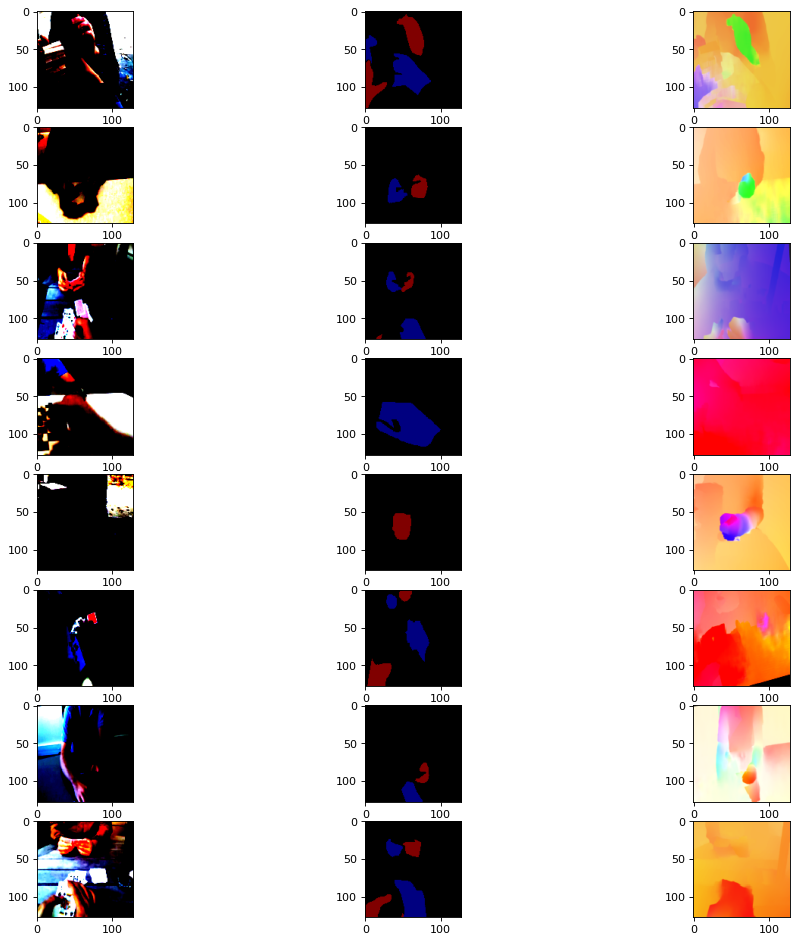

[DEBUG] flo values after reading flow image files:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234

label values: tensor([0, 1, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)


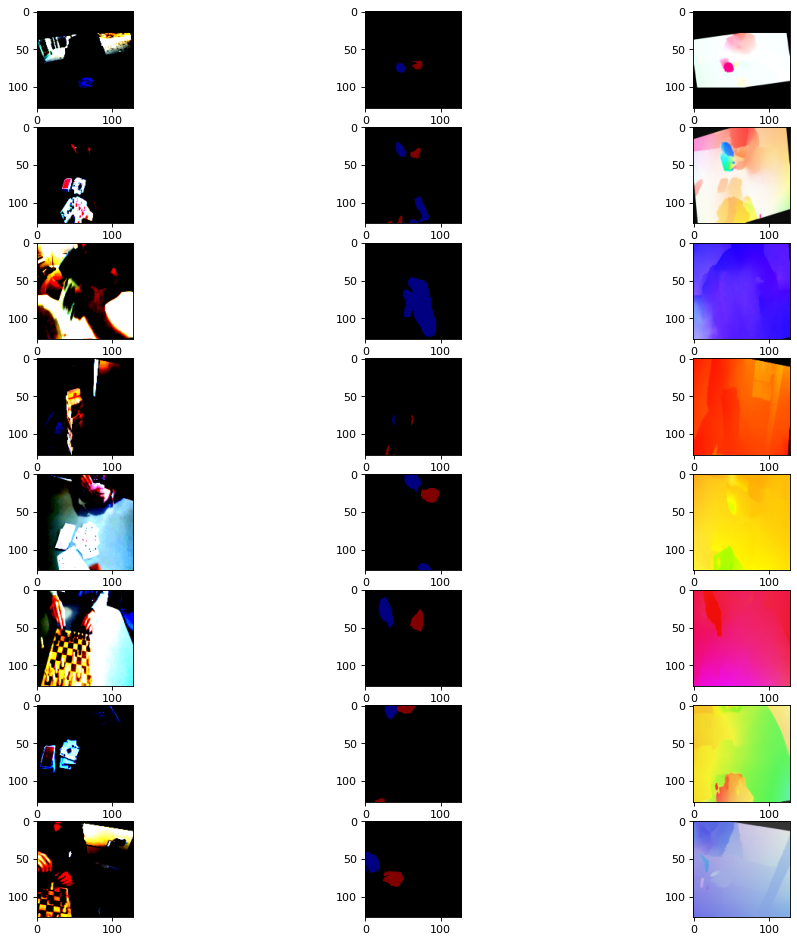

[DEBUG] flo values after reading flow image files:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233

label values: tensor([0, 1, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)


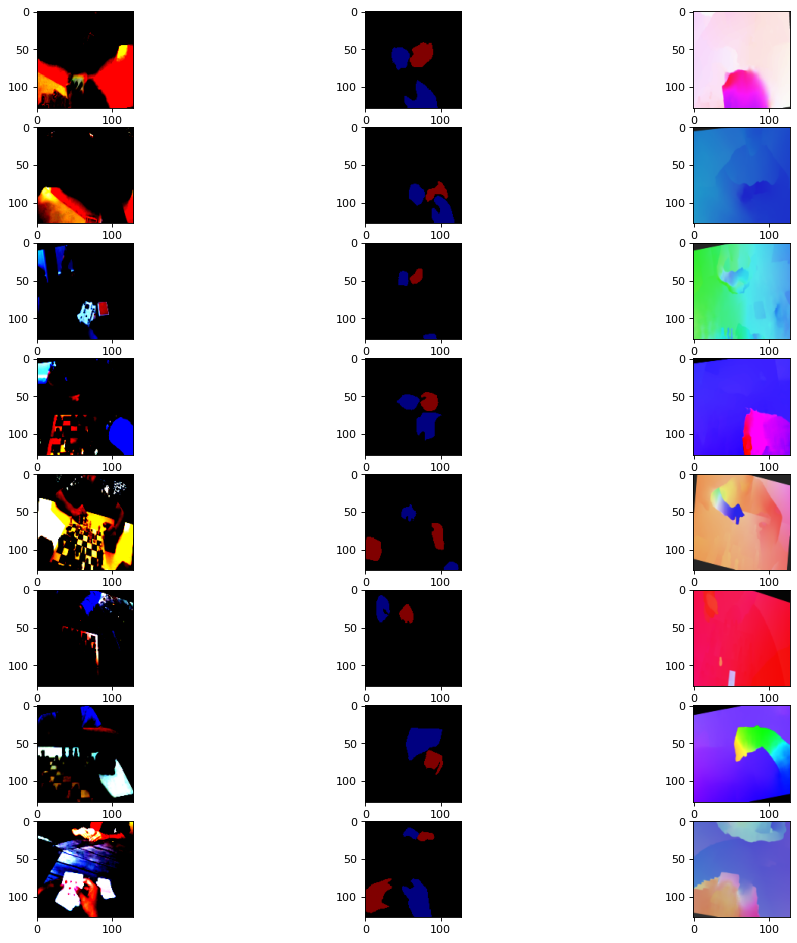

[DEBUG] flo values after reading flow image files:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233

label values: tensor([0, 1, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)
batch item 8 img shape: (128, 128, 3) label shape: (128, 128) flo shape: (128, 128, 3)


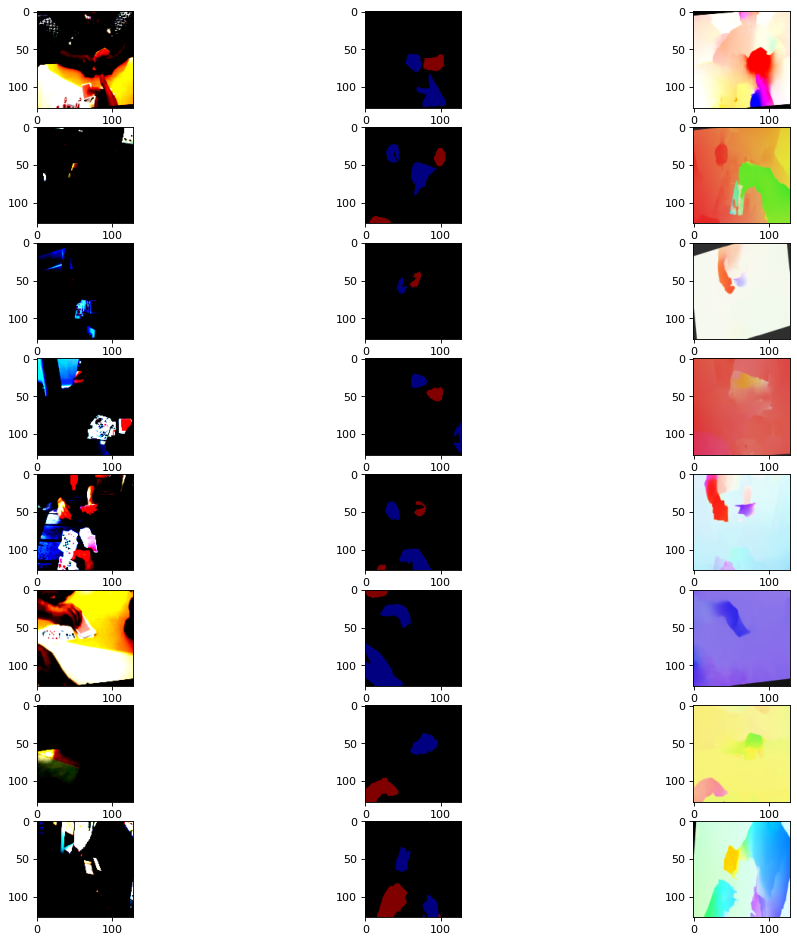

[DEBUG] flo values after reading flow image files:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233

error: OpenCV(4.4.0) /tmp/pip-req-build-cg56sov1/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [19]:
if __name__ == '__main__':

    print("dataset length: ",len(dset))
    
    trainloader = dt.DataLoader(dset, batch_size=bs, shuffle=True)

    for i, data in enumerate(trainloader): # i = batch idx , data = (img , label) (as tensors - first dim is batch size)
        img, label, flo = data
        img = img.numpy()
        flo = flo.numpy()
        img = np.transpose(img, [0,2,3,1])
        flo = np.transpose(flo, [0,2,3,1])
        print("label values:",label.unique())
    
        f, axarr = plt.subplots(bs, 3, figsize=(15, 15), dpi=80)
        
        for j in range(bs):
            print("batch item {} img shape: {} label shape: {} flo shape: {}".format(bs,img[j].shape,label.numpy()[j].shape, flo[j].shape))
            axarr[j,0].imshow(img[j])
            axarr[j,1].imshow(dset.decode_segmap(np.squeeze(label[j].numpy())))
            axarr[j,2].imshow(flo[j])
        plt.show()
    
    plt.close()


## Define DataLoaders

In [ ]:
# Define Train/Val Loaders
    
def data_loader(dataset_name = DATASET, batch_size = BATCH_SIZE, split = "train"
                , augmentations = None, shuffle = True
                , aug_pascal_with_sbd = False, overfit_pascal=True):
    
    
    if dataset_name == "pascal":
        
        data_path = "/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/"

        if overfit_pascal:
            data_path = "/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/"
            dataset = pascalVOCLoader_reduced(root = data_path, split = split
                                  , is_transform = True, augmentations = None
                                  , img_norm = True, aug_with_sbd = False)
        else:
            dataset = pascalVOCLoader(root = data_path, split = split
                                  , is_transform = True, augmentations = augmentations
                                  , img_norm = True, aug_with_sbd = aug_pascal_with_sbd)
            
        
    if dataset_name == "egohands":
        
        assert OVERFIT == False , "no overfitting set defined for egohands dataset"
        data_path = "/gpfs/home/fnouraei/data/fnouraei/"
        dataset = EgoHandsLoader(root=data_path, split=split
                                  , is_transform=True, augmentations=augmentations
                                  , img_norm = True
                                  , include_flo = True)
    
    print("dataset {} {} size: {} \n".format(dataset_name,split,len(dataset))) 
    loader = dt.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=1)
    
    return loader

# TRAIN

In [ ]:
### TRAIN

# libraries
import os
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(17)


def main():
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    nEpochs = NUM_EPOCHS 
    terminal_show_freq = 60 

    root = "."
        
    # perform data augmentations on training samples
    #augs = None 
    augs = Compose([RandomSizedCrop(100), RandomRotate(10)
                    , AdjustGamma(gamma = 2.2), AdjustContrast(cf=0.4)])
    
    # augment dataset with Berkeley SBD
    sbd_aug = False 
    
    train_loader = data_loader(dataset_name = DATASET, split = "train"
                               , augmentations = augs, aug_pascal_with_sbd=sbd_aug
                               , overfit_pascal=OVERFIT)
    val_loader = data_loader(dataset_name = DATASET, split = "val" 
                             , augmentations = None, aug_pascal_with_sbd=sbd_aug, overfit_pascal=OVERFIT)
    
    
    n_classes = OUTPUT_CLASSES
    
    #optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()
        
    # whatever you are timing goes here
    
    if MODEL == "segnet":
        model = SegNet(in_channels=IN_CHANNELS, n_classes=OUTPUT_CLASSES
                       , pretrained = PRETRAINED)
    if MODEL == "unet":
        model = UNet(in_channels=IN_CHANNELS, n_classes=OUTPUT_CLASSES)
        
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    
    #scheduler = ReduceLROnPlateau(optimizer, 'min', verbose = True)
    scheduler = None

    model = model.to(device)
    print("Model transferred to GPU.....")

    
    if LOSS_TYPE == "BCE":
        criterion = WeightedCrossEntropyLoss(classes = OUTPUT_CLASSES, do_weight = False)
    elif LOSS_TYPE == "WBCE": 
        criterion = WeightedCrossEntropyLoss(classes = OUTPUT_CLASSES, do_weight = True)
    elif LOSS_TYPE == "Dice":
        criterion = DiceLoss(classes = OUTPUT_CLASSES)
    else:
        print("Loss type not determined...using WBCE by default:")
        criterion = WeightedCrossEntropyLoss(classes = OUTPUT_CLASSES, do_weight = True)

        
    trainer = Trainer(root=root, nEpochs=nEpochs, terminal_show_freq=terminal_show_freq,
                      dataset_name = DATASET, classes = OUTPUT_CLASSES, model=model,
                      criterion=criterion, optimizer=optimizer, train_data_loader=train_loader,
                      valid_data_loader=val_loader, lr_scheduler=scheduler, device = device)
    print("STARTING TRAINING...")
    trainer.training()
    
    end.record()
    
    print("FINISHING TRAINING...")
    
    # Waits for everything to finish running
    torch.cuda.synchronize()
    print("time elapsed at training:{}: ".format(start.elapsed_time(end)))  # milliseconds

    
if __name__ == '__main__':
    main()



# LOAD N' TEST 

In [ ]:
# Reading and evaluating the trained model

root = "."
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path_trained = os.path.join(root,"trained",MODEL,"models")
model_name = MODEL+"_"+DATASET+"_ep1000_lr0.0001_bs8_pretrained_WBCE"

if MODEL == "segnet":
    model = SegNet(in_channels=IN_CHANNELS, n_classes=OUTPUT_CLASSES)
if MODEL == "unet":
    model = UNet(in_channels=IN_CHANNELS, n_classes=OUTPUT_CLASSES)    
    
model = model.to(device)

if str(device) == 'cuda':
    print('loading model on GPU')
    model.load_state_dict(torch.load(os.path.join(path_trained, model_name + '.pth')))
else:
    print('loading model on CPU')
    model.load_state_dict(torch.load(os.path.join(path_trained, model_name  +'.pth', map_location='cpu')))   
model.eval()

print('Trained model is loaded and ready for evaluation.')

## Visualize Results

In [ ]:
if DATASET== "pascal":
    local_path = '/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/'
    
    if OVERFIT:
        dst = pascalVOCLoader_reduced(root=local_path,img_size=(INPUT_SIZE,INPUT_SIZE), split = "train"
                                      , is_transform=True, augmentations=None)
    else:
        dst = pascalVOCLoader(root=local_path,img_size=(INPUT_SIZE,INPUT_SIZE), split = "val"
                              , is_transform=True, augmentations=None
                              , img_norm = True, aug_with_sbd = True)
if DATASET== "egohands":
    local_path = "/gpfs/home/fnouraei/data/fnouraei/"
    dst = EgoHandsLoader(root=local_path,img_size=(INPUT_SIZE,INPUT_SIZE), is_transform=True, augmentations=None)

if OVERFIT:
    test_loader = data_loader(dataset_name = DATASET, batch_size = BATCH_SIZE
                               , split="train",  overfit_pascal=OVERFIT)
else:
    test_loader = data_loader(dataset_name = DATASET, batch_size = BATCH_SIZE, split="test",shuffle = False)
    
print("qualitative results on test data:")

for batch_idx, input_tuple in enumerate(test_loader):
    #some transorms to show image in cpu:
    img = input_tuple[0]
    lbl = input_tuple[1]
    img = img.numpy()[:, ::-1, :, :]
    img = np.transpose(img, [0,2,3,1])

    input_tensor, target = prepare_input(input_tuple=input_tuple, cuda=True if torch.cuda.is_available() else False)
    input_tensor.requires_grad = False
    
    # ********************************  Visualize Results ************************************
    
    with torch.no_grad():
        
        output = model(input_tensor)
    
        # Create 2D output array with different indices for each class (Collapse 1-hot tensor to 2D array)
        
        predicted_labels = np.zeros((BATCH_SIZE, output.shape[-2], output.shape[-1]))

        fig, ax = plt.subplots(BATCH_SIZE,3,figsize=(15,15))
        
        for item in range(BATCH_SIZE):

            lbl_array = output[item].detach().cpu().numpy()
            predicted_labels[item] = np.argmax(lbl_array, axis = 0)
                        
            ax[item,0].imshow(img[item]) #show the 1st item in batch
            ax[item,1].imshow(dst.decode_segmap(target[item].detach().cpu().numpy()))
            ax[item,2].imshow(dst.decode_segmap(predicted_labels[item]))


## Evaluate Performance

In [ ]:
dict_class_names = {"pascal":  # For other datasets, add more keys
                    
                    ["bg"
                     ,"aeroplane"
                     ,"bicycle"  
                     ,"bird" 
                     ,"boat"  
                     ,"bottle"  
                     ,"bus" 
                     ,"car" 
                     ,"cat"
                     ,"chair"
                     ,"cow"
                     ,"dining table" 
                     ,"dog"
                     ,"horse"
                     ,"motorbike" 
                     ,"person"
                     ,"potted plant"
                     ,"sheep"
                     ,"sofa"
                     ,"train"
                     ,"tv/monitor"]   
                  
                , "egohands": 
                    [
                        "bg"
                        ,"left"
                        ,"right"
                    ]
                   
                   } 

if DATASET== "pascal":
    local_path = '/gpfs/home/fnouraei/data/fnouraei/VOC/VOCdevkit/VOC2012/'
    if OVERFIT:
        dst_test = pascalVOCLoader_reduced(root=local_path, img_size=(INPUT_SIZE,INPUT_SIZE), split = "train"
                                      , is_transform=True, augmentations=None)
    else:
        dst_test = pascalVOCLoader(root=local_path,img_size=(INPUT_SIZE,INPUT_SIZE), split = "val"
                                   , is_transform=True, augmentations=None
                                  , aug_with_sbd = False)
if DATASET== "egohands":
    local_path = "/gpfs/home/fnouraei/data/fnouraei/"
    dst_test = EgoHandsLoader(root=local_path,img_size=(INPUT_SIZE,INPUT_SIZE), split = "val", is_transform=True, augmentations=None)


if OVERFIT:
    test_loader = data_loader(dataset_name = DATASET, batch_size = BATCH_SIZE
                            , split="train", overfit_pascal=OVERFIT)
else:
    test_loader = data_loader(dataset_name = DATASET, batch_size = BATCH_SIZE
                            , split="val", overfit_pascal=False)


iou_list = [np.zeros((1,len(dict_class_names[DATASET])))]*len(dst_test)
dce_list = [np.zeros((1,len(dict_class_names[DATASET])))]*len(dst_test)
sen_list = [np.zeros((1,len(dict_class_names[DATASET])))]*len(dst_test)
pre_list = [np.zeros((1,len(dict_class_names[DATASET])))]*len(dst_test)
gt_labels = [None]*len(dst_test) 

print("quantitative results on test data:")


pred_flat = []
gt_flat = []

for batch_idx, input_tuple in enumerate(test_loader):

    input_tensor, target = prepare_input(input_tuple=input_tuple, cuda=True if torch.cuda.is_available() else False)
    input_tensor.requires_grad = False

    # ********************************  Get Results ************************************

    with torch.no_grad():

        output = model(input_tensor)

        # Collapse 1-hot tensor to 2D array

        predicted_labels = np.zeros((BATCH_SIZE, output.shape[-2], output.shape[-1]))

        for item in range(BATCH_SIZE):
            try:
                out_array = output[item].detach().cpu().numpy()

            #ignore index errors if len(dataset)/batchsize is not an integer
            except IndexError: 
                break
            #print("[DEBUG] out shape: ", out_array.shape)
            predicted_labels[item] = np.argmax(out_array, axis = 0) 
            gt_labels[item] = target[item].detach().cpu().numpy()

            pred_flat.append(predicted_labels[item].reshape(1,-1))
            gt_flat.append(gt_labels[item].reshape(1,-1))

# calculate metrics
iou, dce, sen, pre = get_performance_measures(np.array(gt_flat).reshape(1,-1)
                                            , np.array(pred_flat).reshape(1,-1)
                                            , names = dict_class_names[DATASET]
                                            , print_on = False)

import pandas as pd
# report metrics
results = np.concatenate((iou.reshape(1,-1),(dce.reshape(1,-1))),axis=0)
pd.set_option('max_columns', None)
results = pd.DataFrame(data = results, index = ["IOU","Dice"], columns = dict_class_names[DATASET])
display(results)

miou = np.mean(iou)
print("[INFO] mean IOU: ",miou)
mdce = np.mean(dce)
print("[INFO] mean Dice Coeff.: ",mdce)

In [ ]:
#TODO: add and concat motion to egohands 
#     find motion mean and std
#     check skip segnet
#     train on motion
#     train on images
#     train on both
#     test unet for egohands images
        